In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import random

import soundfile as sf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

In [3]:
CWD = Path().resolve()
PROJECT_ROOT = CWD.parents[1]
OUT_ROOT = PROJECT_ROOT / "data" / "processed" / "hls_cmds"

CSV_HS = OUT_ROOT / "ls_segments.csv"
assert CSV_HS.exists(), CSV_HS

OUT_DIR = OUT_ROOT / "baseline_runs_ls_all_labels"
OUT_DIR.mkdir(parents=True, exist_ok=True)

CSV_HS


WindowsPath('C:/Users/MSI/Documents/Persoonlijke Projecten/AI-Onderzoeksvragen/research_questions/heart_and_lungsounds/data/processed/hls_cmds/ls_segments.csv')

In [4]:
df = pd.read_csv(CSV_HS)

df["audio_path_resolved"] = (df["audio_path"].astype(str).apply(lambda p: (PROJECT_ROOT / p).resolve()))
df["audio_exists"] = df["audio_path_resolved"].apply(lambda p: Path(p).exists())
assert df["audio_exists"].all(), "Unresolved audio paths (check prep output paths)."

LABEL_COL = "lung_label"
df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()

df.columns.tolist(), df[LABEL_COL].value_counts().head(20)


(['category',
  'location',
  'gender',
  'file_name',
  'wav_path',
  'heart_label',
  'lung_label',
  'mix_label',
  'segment_index',
  'seg_start_sec',
  'seg_end_sec',
  'audio_path',
  'audio_path_resolved',
  'audio_exists'],
 lung_label
 Normal             156
 Pleural Rub        117
 Coarse Crackles    117
 Rhonchi            104
 Wheezing            91
 Fine Crackles       65
 Name: count, dtype: int64)

In [5]:
LABEL_COL = "lung_label"

df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()

# Gebruik alle labels zoals ze in de dataset voorkomen
LS_ALL_LABELS = [
    "Normal",
    "Pleural Rub",
    "Coarse Crackles",
    "Rhonchi",
    "Wheezing",
    "Fine Crackles",
]

# 1-op-1 mapping (expliciet, maar geen reductie)
LS_LABEL_MAP = {l: l.upper().replace(" ", "_") for l in LS_ALL_LABELS}

df["label_reduced"] = df[LABEL_COL].map(LS_LABEL_MAP)
df = df.dropna(subset=["label_reduced"]).reset_index(drop=True)

REDUCED_LABELS = sorted(df["label_reduced"].unique().tolist())
reduced2id = {l: i for i, l in enumerate(REDUCED_LABELS)}

df["y"] = df["label_reduced"].map(reduced2id).astype(int)

df["label_reduced"].value_counts()


label_reduced
NORMAL             156
PLEURAL_RUB        117
COARSE_CRACKLES    117
RHONCHI            104
WHEEZING            91
FINE_CRACKLES       65
Name: count, dtype: int64

In [6]:
raw_unique = sorted(df[LABEL_COL].unique())
mapped_unique = sorted(df["label_reduced"].unique())
print("Raw labels:", raw_unique)
print("Mapped labels:", mapped_unique)

Raw labels: ['Coarse Crackles', 'Fine Crackles', 'Normal', 'Pleural Rub', 'Rhonchi', 'Wheezing']
Mapped labels: ['COARSE_CRACKLES', 'FINE_CRACKLES', 'NORMAL', 'PLEURAL_RUB', 'RHONCHI', 'WHEEZING']


In [7]:
GROUP_COL = "file_name" if "file_name" in df.columns else "wav_path"
GROUP_COL

'file_name'

In [8]:
from sklearn.model_selection import GroupShuffleSplit
import numpy as np

def _has_all_labels(df_split, label_col, labels):
    present = set(df_split[label_col].unique().tolist())
    return all(l in present for l in labels)

def split_by_group_with_label_coverage(
    df,
    group_col,
    label_col,
    labels,
    seed=42,
    test_size=0.15,
    val_size=0.15,
    max_tries=2000,
    min_per_split=1,   # zet bv 1 of 2
):
    rng = np.random.RandomState(seed)
    labels = list(labels)

    def meets_min(df_split):
        vc = df_split[label_col].value_counts()
        return all(vc.get(l, 0) >= min_per_split for l in labels)

    for _ in range(max_tries):
        s1 = int(rng.randint(0, 10_000_000))
        gss1 = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=s1)
        tr_idx, te_idx = next(gss1.split(df, groups=df[group_col]))
        df_tr = df.iloc[tr_idx].reset_index(drop=True)
        df_te = df.iloc[te_idx].reset_index(drop=True)

        if not _has_all_labels(df_te, label_col, labels):
            continue
        if min_per_split and not meets_min(df_te):
            continue

        # val uit train trekken
        s2 = int(rng.randint(0, 10_000_000))
        # val_size is fractie van totale df; binnen df_tr moet je hernormaliseren:
        val_frac_within_tr = val_size / (1.0 - test_size)

        gss2 = GroupShuffleSplit(n_splits=1, test_size=val_frac_within_tr, random_state=s2)
        tr2_idx, va_idx = next(gss2.split(df_tr, groups=df_tr[group_col]))
        df_train = df_tr.iloc[tr2_idx].reset_index(drop=True)
        df_val   = df_tr.iloc[va_idx].reset_index(drop=True)

        ok = (
            _has_all_labels(df_train, label_col, labels) and
            _has_all_labels(df_val,   label_col, labels) and
            _has_all_labels(df_te,    label_col, labels)
        )
        if not ok:
            continue

        if min_per_split:
            if not (meets_min(df_train) and meets_min(df_val) and meets_min(df_te)):
                continue

        return df_train, df_val, df_te

    raise RuntimeError(
        f"Could not find a group split with full label coverage after {max_tries} tries. "
        f"Likely too few groups for some labels."
    )


In [9]:
df_train, df_val, df_test = split_by_group_with_label_coverage(
    df,
    group_col=GROUP_COL,
    label_col="label_reduced",
    labels=REDUCED_LABELS,
    seed=SEED,
    test_size=0.15,
    val_size=0.15,
    max_tries=5000,
    min_per_split=1
)

In [10]:
print("Leakage:",
      len(set(df_train[GROUP_COL]) & set(df_val[GROUP_COL])) == 0,
      len(set(df_train[GROUP_COL]) & set(df_test[GROUP_COL])) == 0,
      len(set(df_val[GROUP_COL]) & set(df_test[GROUP_COL])) == 0)

df.groupby("label_reduced")[GROUP_COL].nunique().sort_values()


Leakage: True True True


label_reduced
FINE_CRACKLES       5
WHEEZING            7
RHONCHI             8
COARSE_CRACKLES     9
PLEURAL_RUB         9
NORMAL             12
Name: file_name, dtype: int64

In [11]:
def class_weights_from_df(df_train, n_classes):
    counts = df_train["y"].value_counts().reindex(range(n_classes), fill_value=0).values.astype(np.float32)
    w = counts.sum() / np.maximum(counts, 1.0)
    w = w / w.mean()
    return torch.tensor(w, dtype=torch.float32)

class_weights_from_df(df_train, len(REDUCED_LABELS))


tensor([0.8491, 1.6981, 0.5660, 0.8491, 1.0189, 1.0189])

In [12]:
def stft_power_db(y, n_fft=256, hop=64):
    y_t = torch.tensor(y, dtype=torch.float32)
    win = torch.hann_window(n_fft)
    spec = torch.stft(y_t, n_fft=n_fft, hop_length=hop, win_length=n_fft, window=win, return_complex=True)
    power = (spec.real**2 + spec.imag**2)
    power = torch.clamp(power, min=1e-10)
    db = 10.0 * torch.log10(power)
    return db.numpy()

def logmel_db(y, sr, n_fft=256, hop=64, n_mels=64, fmin=20.0, fmax=None):
    import librosa
    if fmax is None:
        fmax = sr/2
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop, win_length=n_fft, window="hann"))**2
    mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax)
    M = mel.dot(S)
    M = np.maximum(M, 1e-10)
    db = 10.0 * np.log10(M)
    return db

def minmax_01(x):
    x = x.astype(np.float32)
    mn, mx = float(x.min()), float(x.max())
    if mx - mn < 1e-8:
        return np.zeros_like(x, dtype=np.float32)
    return (x - mn) / (mx - mn)


In [13]:
CACHE_ROOT = OUT_ROOT / "features_cache_hs_labels"
CACHE_ROOT.mkdir(parents=True, exist_ok=True)

def cache_path(feature_type, key):
    d = CACHE_ROOT / feature_type
    d.mkdir(parents=True, exist_ok=True)
    return d / f"{key}.npy"

def make_cache_key(row):
    fn = str(row["file_name"]).replace(os.sep, "_")
    si = int(row["segment_index"])
    return f"{fn}__seg{si:06d}"

def extract_feature(row, feature_type):
    p = Path(row["audio_path_resolved"])
    y, sr = sf.read(str(p), dtype="float32")
    if y.ndim > 1:
        y = np.mean(y, axis=1)

    if feature_type == "logmel":
        feat = logmel_db(y, sr, n_fft=256, hop=64, n_mels=64, fmin=20.0, fmax=sr/2)
    elif feature_type == "stft":
        feat = stft_power_db(y, n_fft=256, hop=64)
    else:
        raise ValueError(feature_type)

    feat = minmax_01(feat).astype(np.float32)
    return feat

def extract_and_cache(row, feature_type):
    key = make_cache_key(row)
    cp = cache_path(feature_type, key)
    if not cp.exists():
        feat = extract_feature(row, feature_type)
        np.save(cp, feat)
    return str(cp)


In [14]:
from torch.utils.data import WeightedRandomSampler

def make_sampler(df_train, n_classes):
    counts = df_train["y"].value_counts().reindex(range(n_classes), fill_value=0).astype(float)
    inv = 1.0 / np.maximum(counts.values, 1.0)
    w = inv[df_train["y"].values]
    return WeightedRandomSampler(weights=torch.tensor(w, dtype=torch.double), num_samples=len(w), replacement=True)

In [15]:
class CachedFeatureDataset(Dataset):
    def __init__(self, df_split, feature_type):
        self.df = df_split.reset_index(drop=True)
        self.files = []
        for _, row in self.df.iterrows():
            cp = cache_path(feature_type, make_cache_key(row))
            if not cp.exists():
                _ = extract_and_cache(row, feature_type)
            self.files.append(str(cp))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.load(self.files[idx]).astype(np.float32)
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        y = int(self.df.loc[idx, "y"])
        return x, y


In [16]:
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(8, 32, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(32, 32, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(32, 32, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 2)),  # reduced stride in height dim
        )

        self.dropout1 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(1, 2000)  # placeholder; we set in forward after we know flatten dim
        self.dropout2 = nn.Dropout(p=0.50)
        self.out = nn.Linear(2000, n_classes)

        self._fc_initialized = False

    def _init_fc(self, x):
        flat_dim = x.shape[1]
        self.fc1 = nn.Linear(flat_dim, 2000).to(x.device)
        self._fc_initialized = True

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        if not self._fc_initialized:
            self._init_fc(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.out(x)

In [17]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, n, correct = 0.0, 0, 0
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        logits = model(xb)
        loss = nn.functional.cross_entropy(logits, yb)
        total_loss += float(loss.item()) * len(yb)
        n += len(yb)
        pred = torch.argmax(logits, dim=1)
        correct += int((pred == yb).sum().item())
        ys.append(yb.cpu().numpy())
        ps.append(pred.cpu().numpy())
    ys = np.concatenate(ys) if ys else np.array([])
    ps = np.concatenate(ps) if ps else np.array([])
    return total_loss / max(n, 1), correct / max(n, 1), ys, ps


In [18]:
def run_experiment(feature_type="logmel", use_weights=True, use_sampler=False, epochs=50, batch_size=64, lr=1e-3):
    assert not (use_weights and use_sampler), "Use either class weights OR sampler (not both)."

    run_dir = OUT_DIR / f"{feature_type}__weights_{int(use_weights)}__sampler_{int(use_sampler)}"
    run_dir.mkdir(parents=True, exist_ok=True)

    ds_tr  = CachedFeatureDataset(df_train, feature_type)
    ds_va  = CachedFeatureDataset(df_val, feature_type)
    ds_te  = CachedFeatureDataset(df_test, feature_type)

    sampler = None
    if use_sampler:
        sampler = make_sampler(df_train, n_classes=len(REDUCED_LABELS))

    dl_tr = DataLoader(
        ds_tr,
        batch_size=batch_size,
        sampler=sampler,
        shuffle=(sampler is None),
        num_workers=0
    )
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=0)
    dl_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False, num_workers=0)

    model = SmallCNN(n_classes=len(REDUCED_LABELS)).to(DEVICE)

    if use_weights:
        w = class_weights_from_df(df_train, len(REDUCED_LABELS)).to(DEVICE)
        criterion = nn.CrossEntropyLoss(weight=w)
    else:
        criterion = nn.CrossEntropyLoss()

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    best_val_loss = float("inf")
    best_path = run_dir / "best.pt"

    for ep in range(1, epochs + 1):
        model.train()
        tr_loss, tr_n, tr_correct = 0.0, 0, 0
        for xb, yb in dl_tr:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            optim.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optim.step()
            tr_loss += float(loss.item()) * len(yb)
            tr_n += len(yb)
            tr_correct += int((torch.argmax(logits, dim=1) == yb).sum().item())

        train_loss = tr_loss / max(tr_n, 1)
        train_acc = tr_correct / max(tr_n, 1)

        val_loss, val_acc, _, _ = evaluate(model, dl_va)

        history.append({
            "epoch": ep,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc
        })

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)

    pd.DataFrame(history).to_csv(run_dir / "history.csv", index=False)

    model.load_state_dict(torch.load(best_path, map_location=DEVICE))

    test_loss, test_acc, y_true, y_pred = evaluate(model, dl_te)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(REDUCED_LABELS))))
    np.save(run_dir / "confusion_matrix.npy", cm)

    rep = classification_report(
        y_true, y_pred,
        labels=list(range(len(REDUCED_LABELS))),
        target_names=REDUCED_LABELS,
        output_dict=True,
        zero_division=0
    )
    pd.DataFrame(rep).T.to_csv(run_dir / "test_classification_report.csv")

    with open(run_dir / "test_summary.txt", "w", encoding="utf-8") as f:
        f.write(f"feature_type: {feature_type}\n")
        f.write(f"use_weights: {use_weights}\n")
        f.write(f"use_sampler: {use_sampler}\n")
        f.write(f"test_loss: {test_loss:.6f}\n")
        f.write(f"test_acc: {test_acc:.6f}\n")

    return str(run_dir)


runs = []
for feat in ["logmel", "stft"]:
    for use_weights in [False, True]:
        runs.append(run_experiment(feature_type=feat, use_weights=use_weights, use_sampler=False, epochs=50))
    for use_sampler in [True]:
        runs.append(run_experiment(feature_type=feat, use_weights=False, use_sampler=use_sampler, epochs=50))

runs

C:\Users\MSI\AppData\Local\Temp\ipykernel_154872\3423897269.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=DEV

['C:\\Users\\MSI\\Documents\\Persoonlijke Projecten\\AI-Onderzoeksvragen\\research_questions\\heart_and_lungsounds\\data\\processed\\hls_cmds\\baseline_runs_ls_all_labels\\logmel__weights_0__sampler_0',
 'C:\\Users\\MSI\\Documents\\Persoonlijke Projecten\\AI-Onderzoeksvragen\\research_questions\\heart_and_lungsounds\\data\\processed\\hls_cmds\\baseline_runs_ls_all_labels\\logmel__weights_1__sampler_0',
 'C:\\Users\\MSI\\Documents\\Persoonlijke Projecten\\AI-Onderzoeksvragen\\research_questions\\heart_and_lungsounds\\data\\processed\\hls_cmds\\baseline_runs_ls_all_labels\\logmel__weights_0__sampler_1',
 'C:\\Users\\MSI\\Documents\\Persoonlijke Projecten\\AI-Onderzoeksvragen\\research_questions\\heart_and_lungsounds\\data\\processed\\hls_cmds\\baseline_runs_ls_all_labels\\stft__weights_0__sampler_0',
 'C:\\Users\\MSI\\Documents\\Persoonlijke Projecten\\AI-Onderzoeksvragen\\research_questions\\heart_and_lungsounds\\data\\processed\\hls_cmds\\baseline_runs_ls_all_labels\\stft__weights_1__s

In [19]:
summary = []
for d in runs:
    rep = pd.read_csv(Path(d) / "test_classification_report.csv", index_col=0)
    if "f1-score" not in rep.columns:
        rep = rep.T
    macro_f1 = float(rep.loc["macro avg", "f1-score"])
    summary.append({"run": Path(d).name, "macro_f1": macro_f1})

summary_df = pd.DataFrame(summary).sort_values("macro_f1", ascending=False).reset_index(drop=True)
summary_df


,run,macro_f1
0,logmel__weights_0__sampler_1,0.692599
1,logmel__weights_1__sampler_0,0.670434
2,logmel__weights_0__sampler_0,0.658832
3,stft__weights_0__sampler_0,0.626104
4,stft__weights_1__sampler_0,0.568098
5,stft__weights_0__sampler_1,0.307166


In [20]:
def exp_title(exp_dir: Path) -> str:
    name = exp_dir.name

    # feature
    feat = name.split("__")[0].upper()

    # strategy flags (support multiple possible naming conventions)
    has_weights = any(tag in name for tag in ["weights_1", "classweights_1", "cw_1"])
    has_sampler = any(tag in name for tag in ["sampler_1", "use_sampler_1", "wrs_1", "weighted_sampler_1"])

    # prefer showing exactly what was used
    if has_weights and has_sampler:
        strat = "Weights + Sampler"
    elif has_weights:
        strat = "Class Weights"
    elif has_sampler:
        strat = "Sampler"
    else:
        strat = "None"

    return f"HLS-CMDS (HS) | Target: Lung (All-classes) | Features: {feat} | Imbalance Handling: {strat}"

def plot_curves(exp_dir: str, dpi=300):
    exp_dir = Path(exp_dir)
    hist = pd.read_csv(exp_dir / "history.csv")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 3.2), dpi=dpi, constrained_layout=True)
    fig.suptitle(exp_title(exp_dir), fontsize=11, fontweight="bold")

    ax1.plot(hist["epoch"], hist["train_acc"], label="Train", linewidth=2)
    ax1.plot(hist["epoch"], hist["val_acc"], label="Validation", linewidth=2)
    ax1.set_xlabel("Epoch"); ax1.set_ylabel("Accuracy"); ax1.set_ylim(0, 1.0)
    ax1.grid(True, alpha=0.3); ax1.legend(frameon=False, fontsize=9)

    ax2.plot(hist["epoch"], hist["train_loss"], label="Train", linewidth=2)
    ax2.plot(hist["epoch"], hist["val_loss"], label="Validation", linewidth=2)
    ax2.set_xlabel("Epoch"); ax2.set_ylabel("Loss")
    ax2.grid(True, alpha=0.3); ax2.legend(frameon=False, fontsize=9)

    fig.savefig(exp_dir / "plot_curves_acc_loss.png", bbox_inches="tight")
    return fig

def plot_cm(exp_dir: str, normalize="true", dpi=300):
    exp_dir = Path(exp_dir)
    cm = np.load(exp_dir / "confusion_matrix.npy").astype(float)

    if normalize == "true":
        denom = cm.sum(axis=1, keepdims=True)
        cm = np.divide(cm, denom, out=np.zeros_like(cm), where=denom != 0)
        fmt = ".2f"
        sub = "Confusion Matrix (Normalized)"
    else:
        fmt = ".0f"
        sub = "Confusion Matrix (Counts)"

    fig, ax = plt.subplots(figsize=(5.8, 4.8), dpi=dpi, constrained_layout=True)
    ax.set_title(f"{exp_title(exp_dir)}\n{sub}", fontsize=10, fontweight="bold")

    im = ax.imshow(cm)
    fig.colorbar(im, ax=ax, fraction=0.05)

    ax.set_xticks(range(len(REDUCED_LABELS))); ax.set_yticks(range(len(REDUCED_LABELS)))
    ax.set_xticklabels(REDUCED_LABELS, rotation=30, ha="right", fontsize=9)
    ax.set_yticklabels(REDUCED_LABELS, fontsize=9)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")

    for i in range(len(REDUCED_LABELS)):
        for j in range(len(REDUCED_LABELS)):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", fontsize=8)

    fig.savefig(exp_dir / f"plot_confusion_matrix_{normalize}.png", bbox_inches="tight")
    return fig

def plot_report(exp_dir: str, dpi=300):
    exp_dir = Path(exp_dir)
    rep = pd.read_csv(exp_dir / "test_classification_report.csv", index_col=0)
    if "f1-score" not in rep.columns:
        rep = rep.T
    rep = rep[["precision", "recall", "f1-score", "support"]].round(3)

    fig, ax = plt.subplots(figsize=(6.5, 3.2), dpi=dpi, constrained_layout=True)
    ax.set_title(f"{exp_title(exp_dir)}\nClassification Report (Test)", fontsize=10, fontweight="bold")
    ax.axis("off")

    table = ax.table(
        cellText=rep.values,
        rowLabels=rep.index.tolist(),
        colLabels=[c.upper() for c in rep.columns],
        loc="center",
        cellLoc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8.5)
    table.scale(1, 1.15)

    fig.savefig(exp_dir / "plot_classification_report.png", bbox_inches="tight")
    return fig


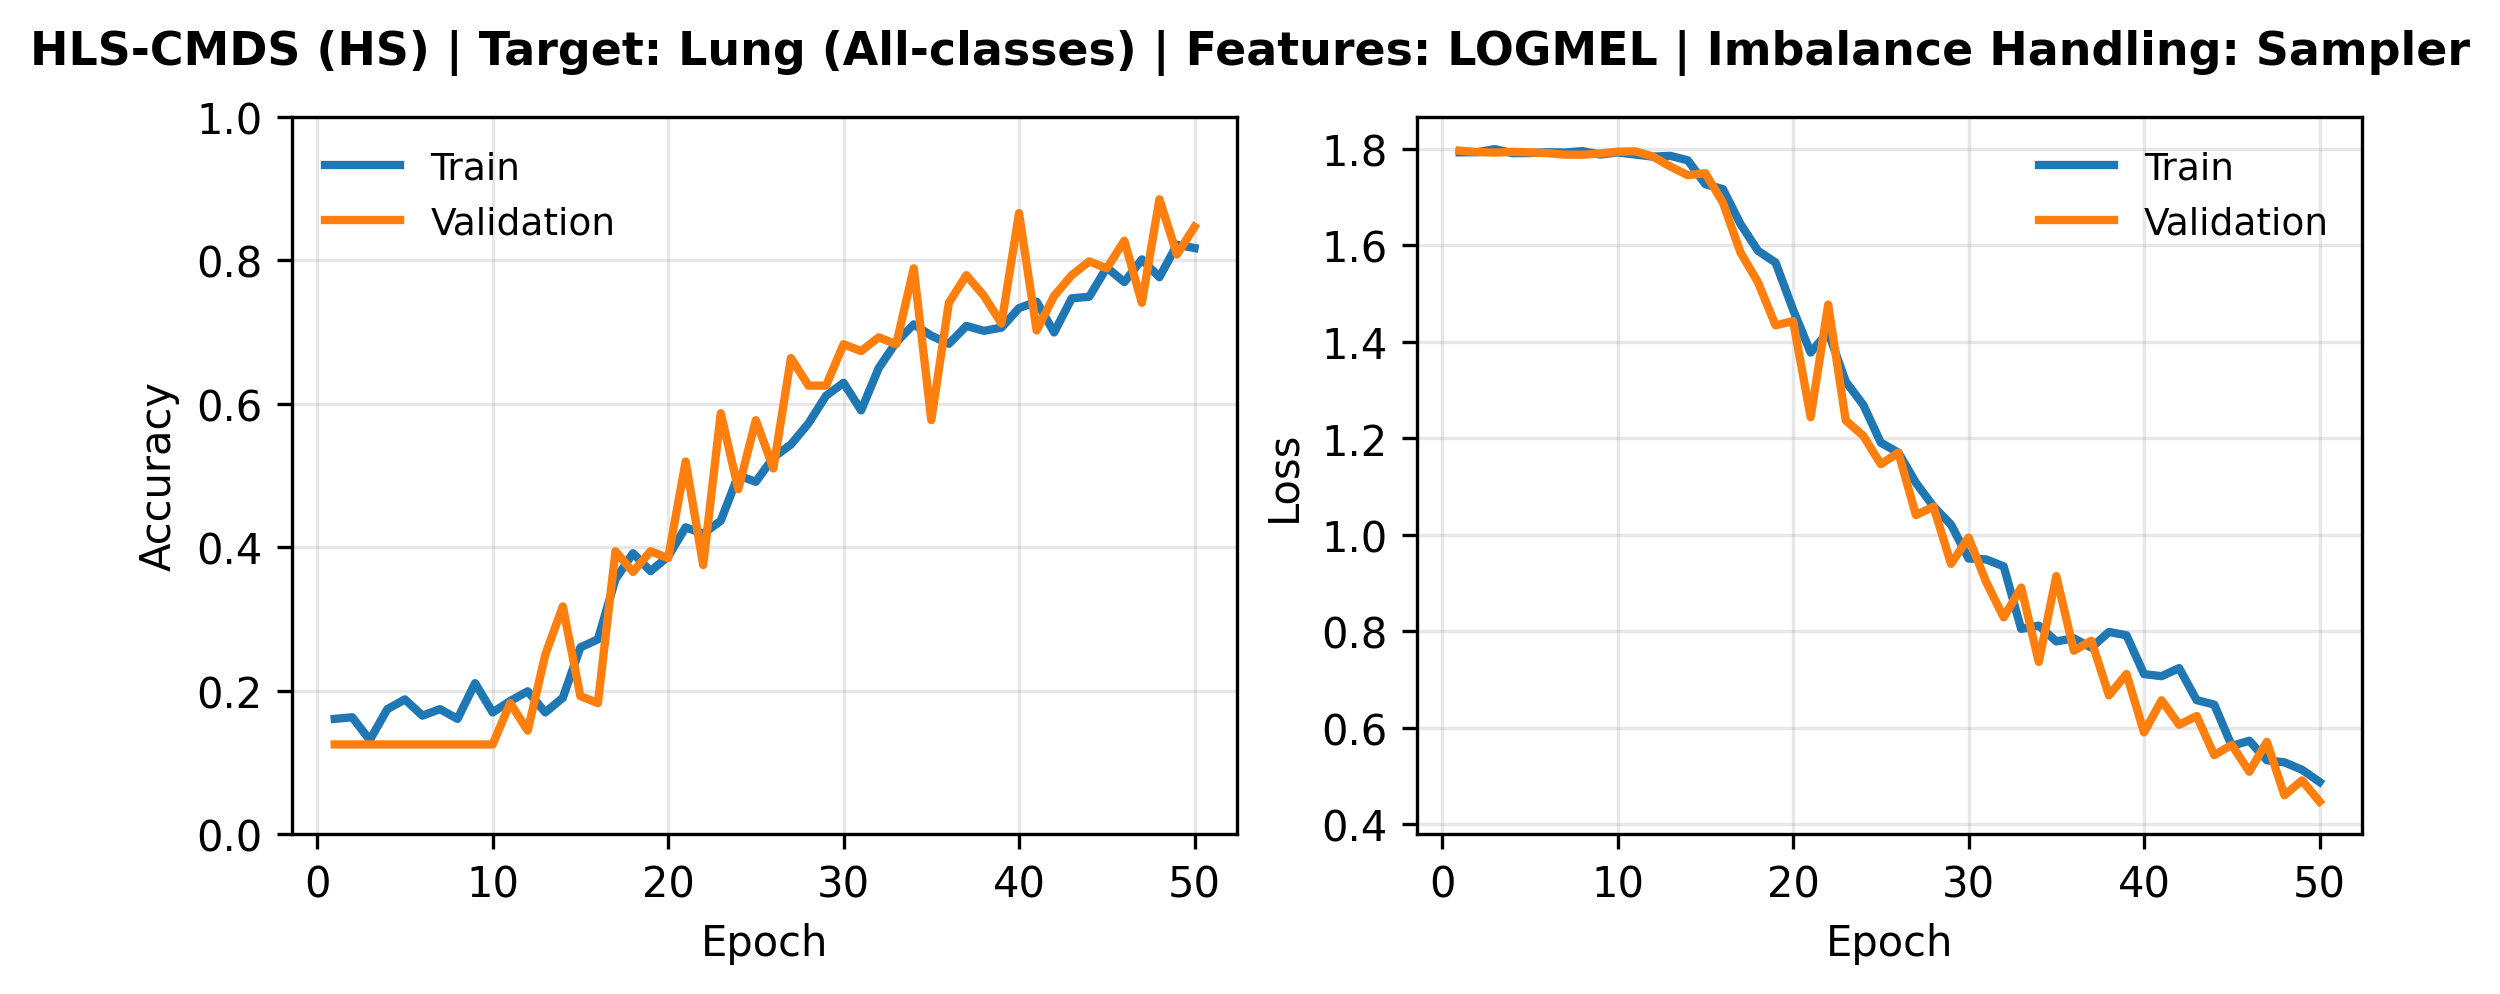

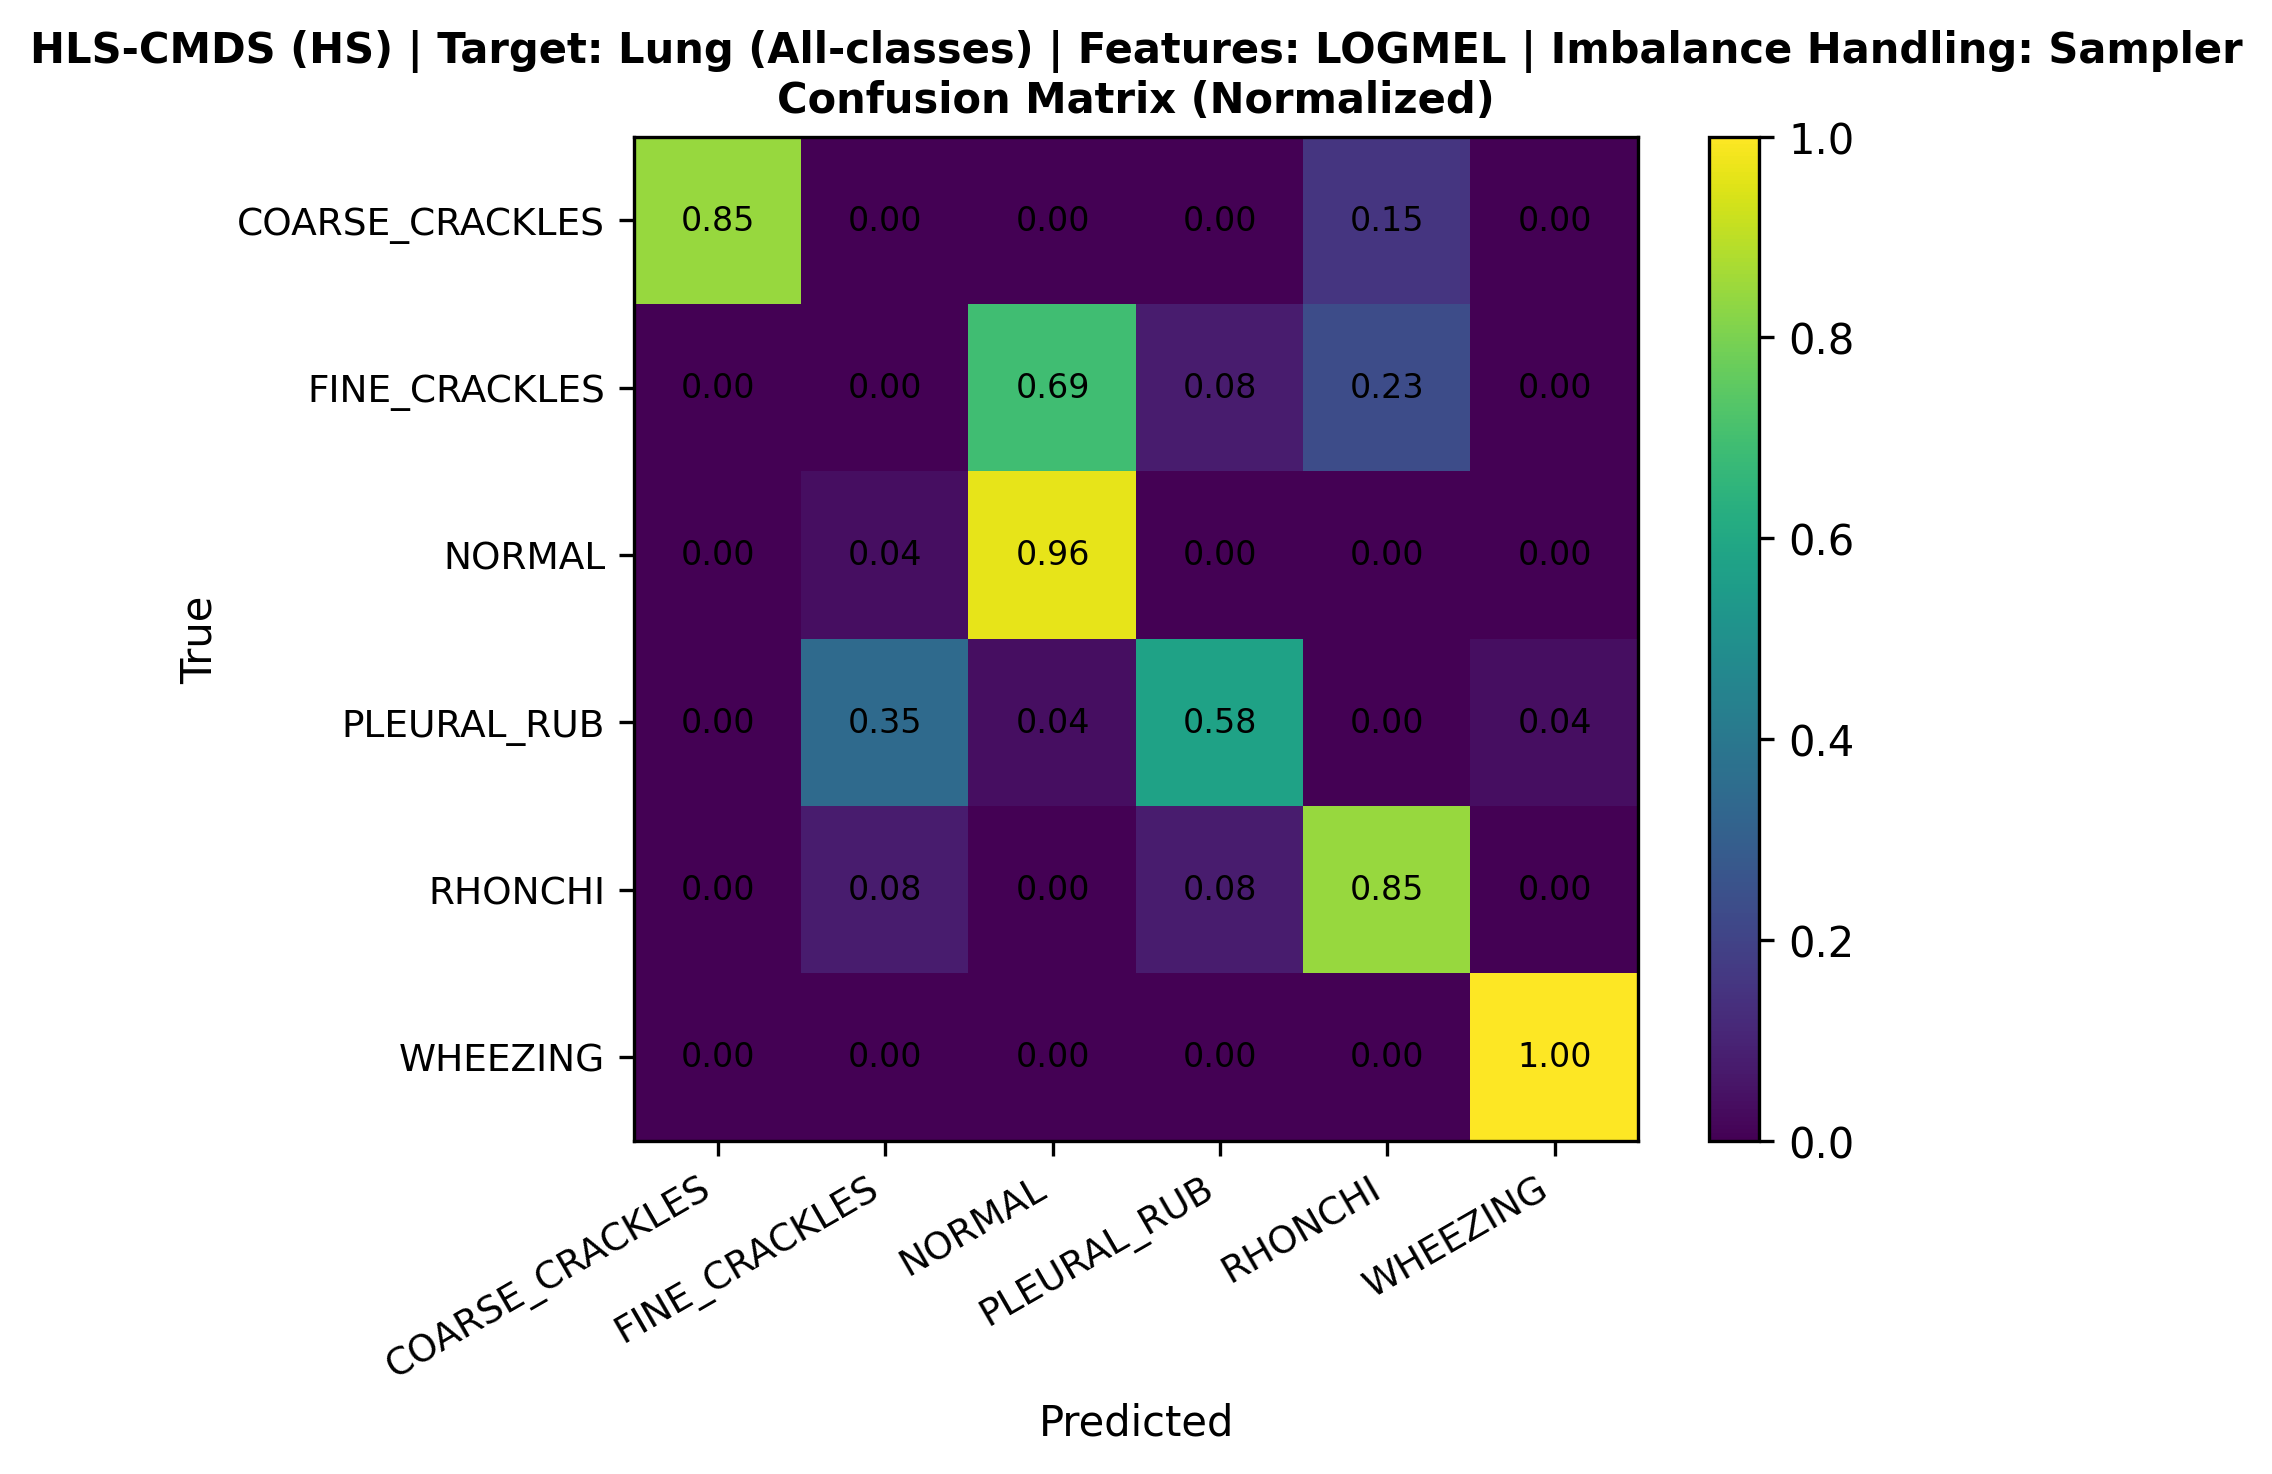

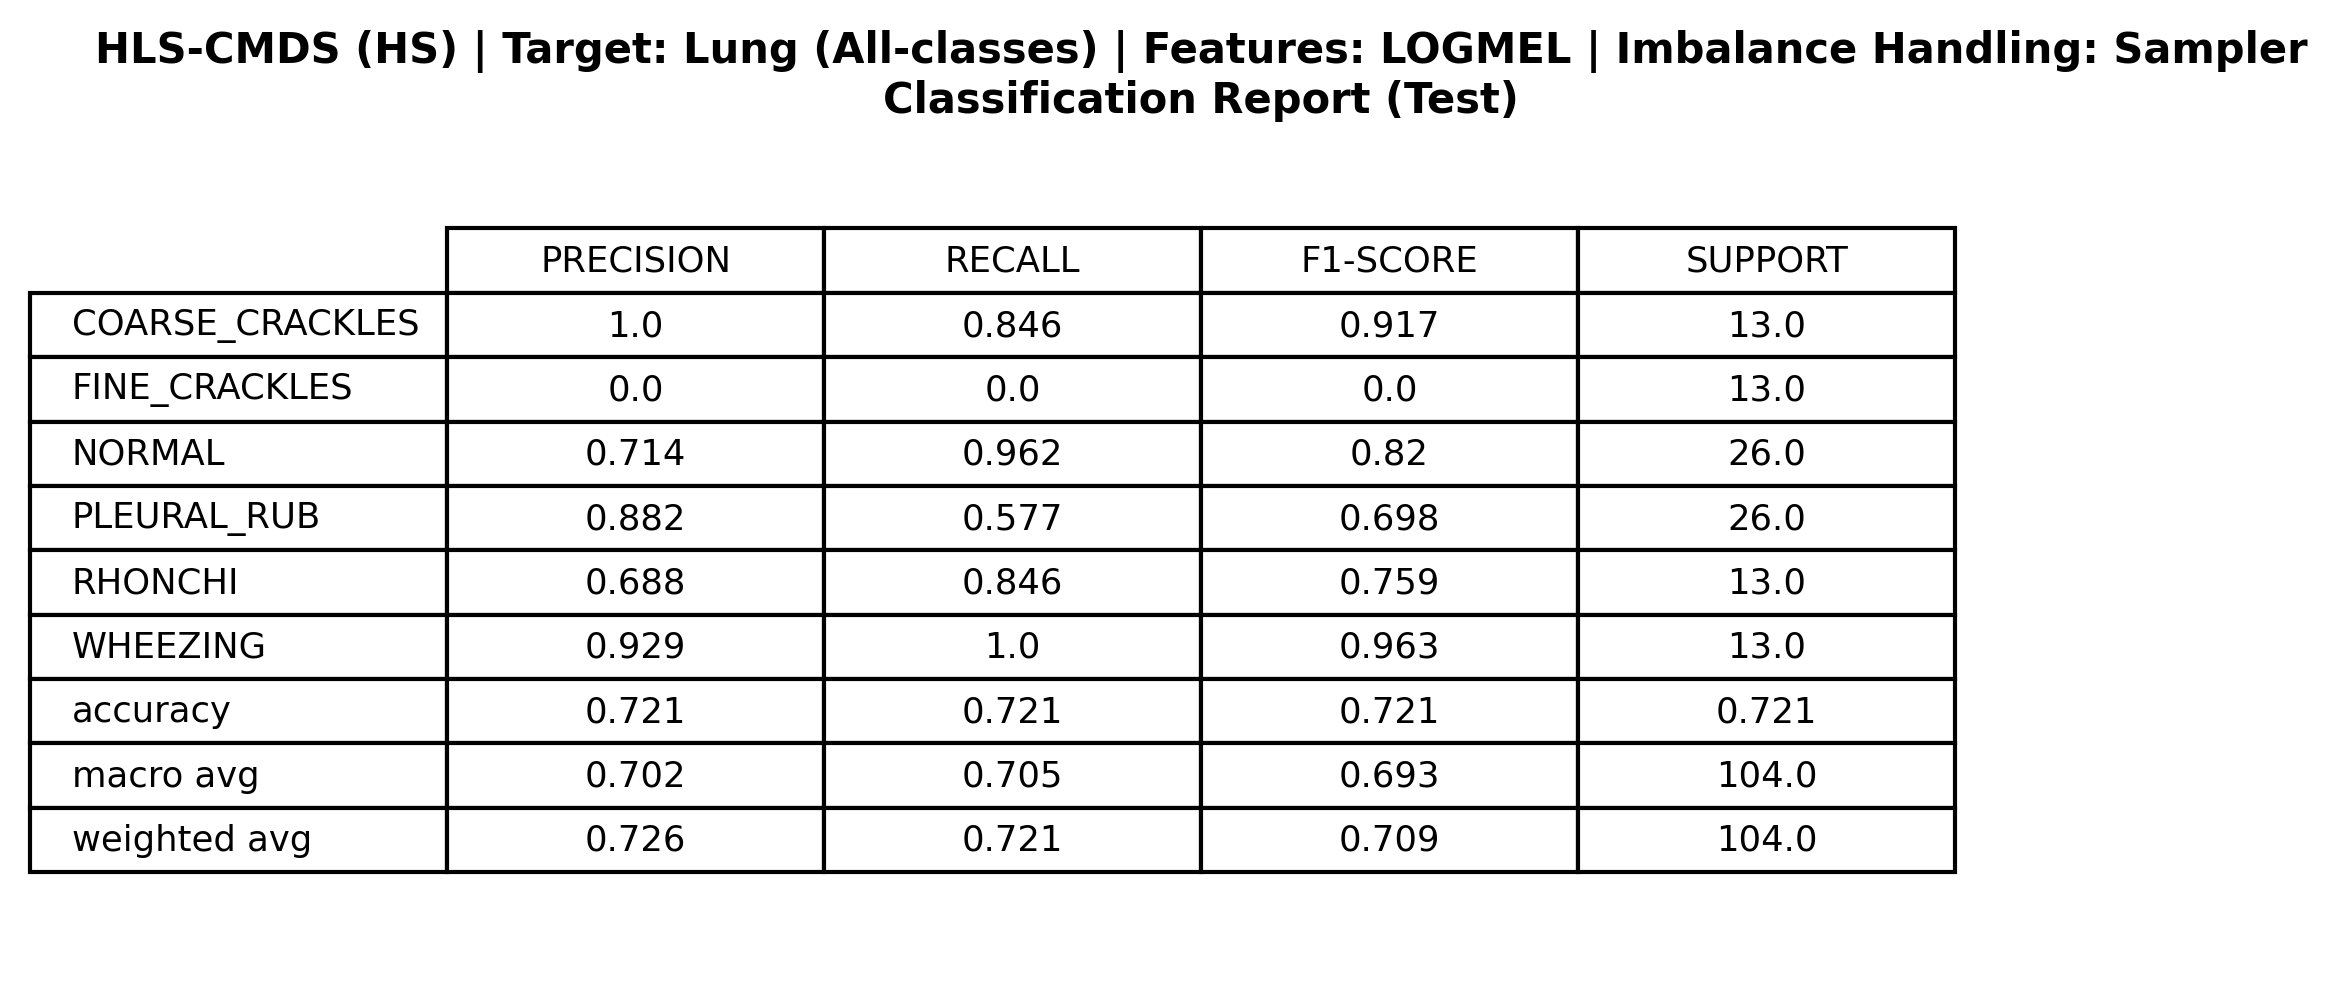

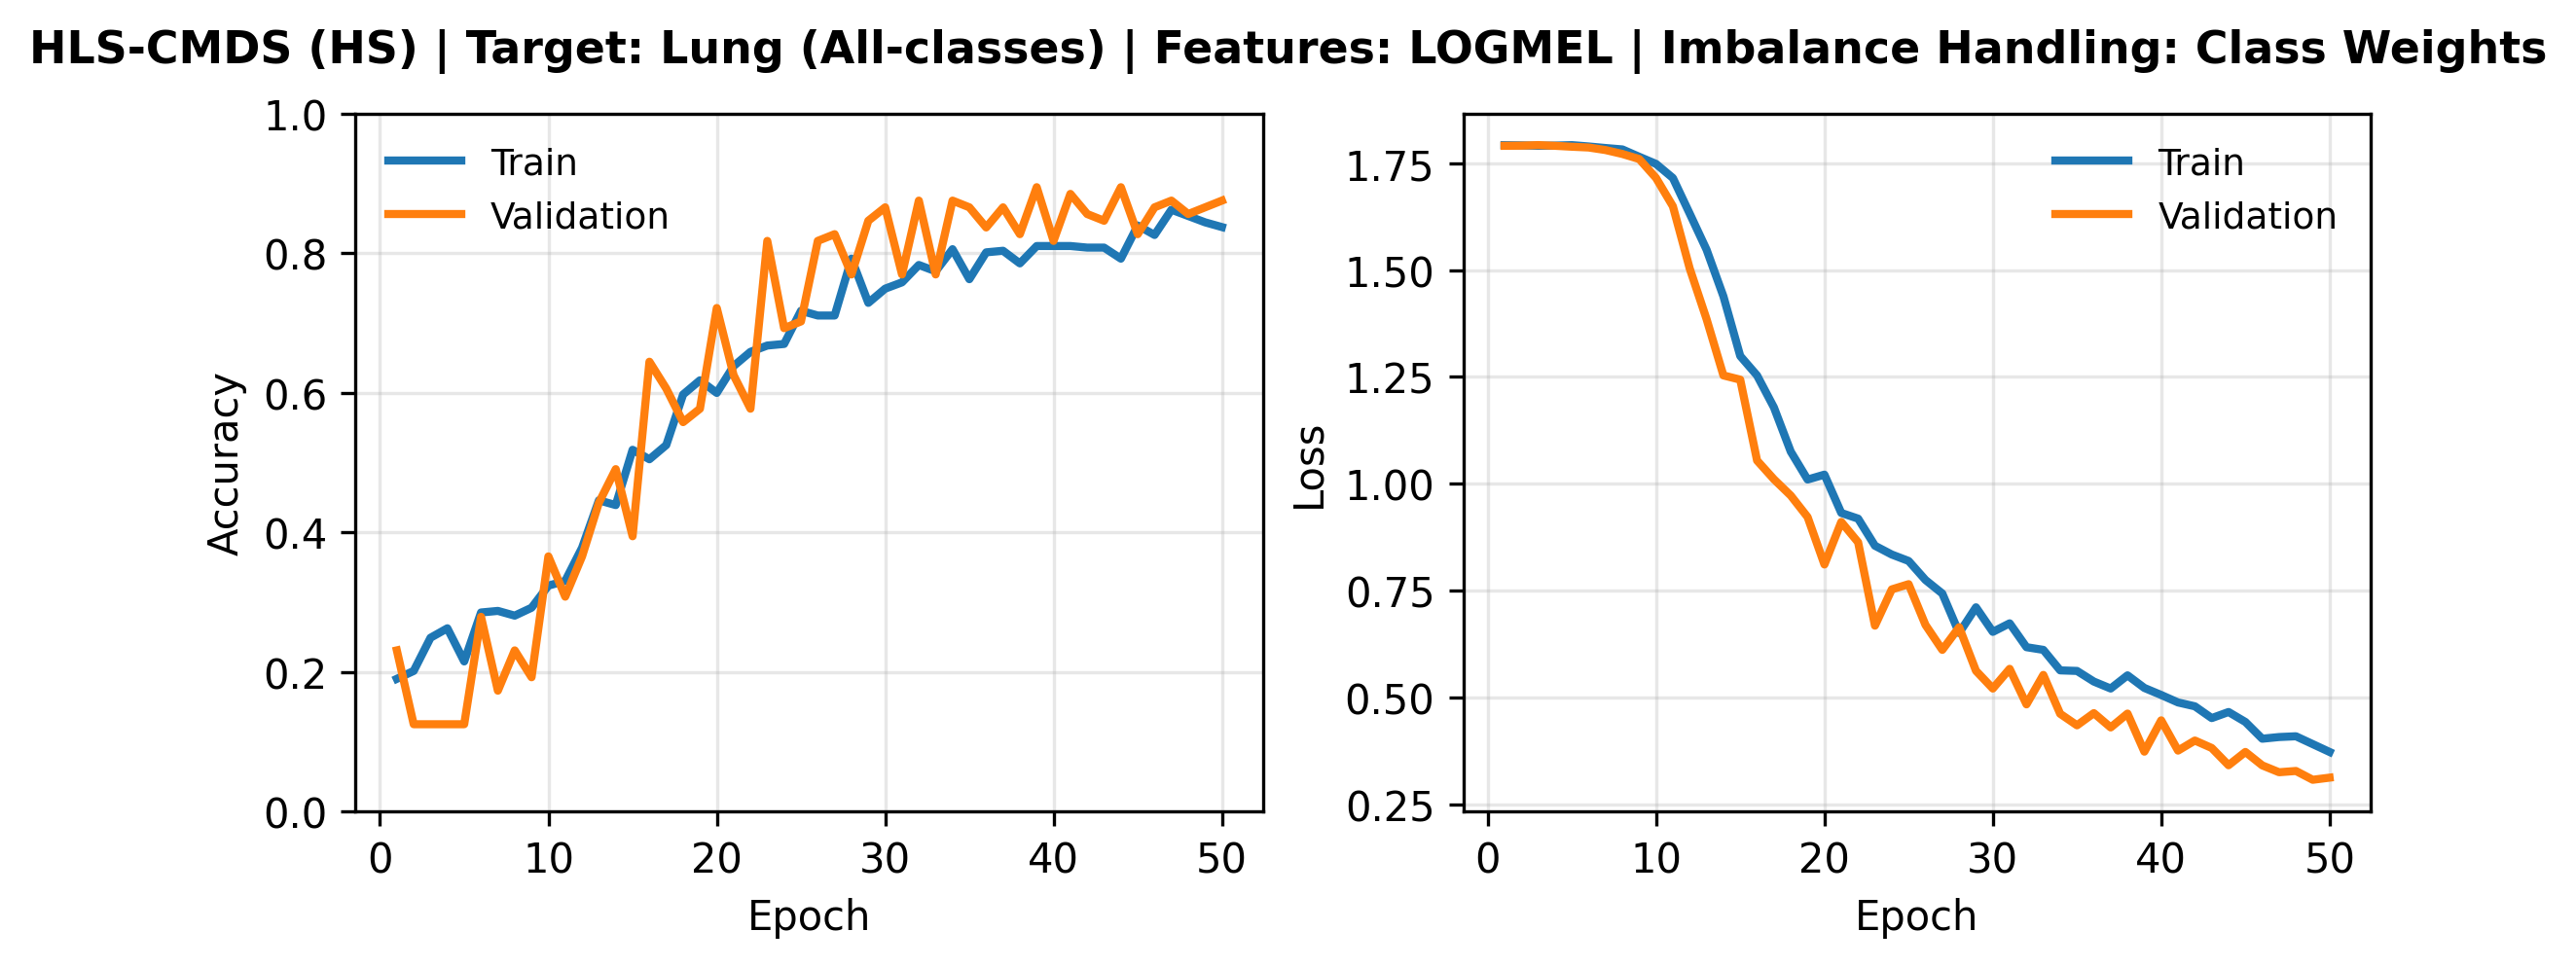

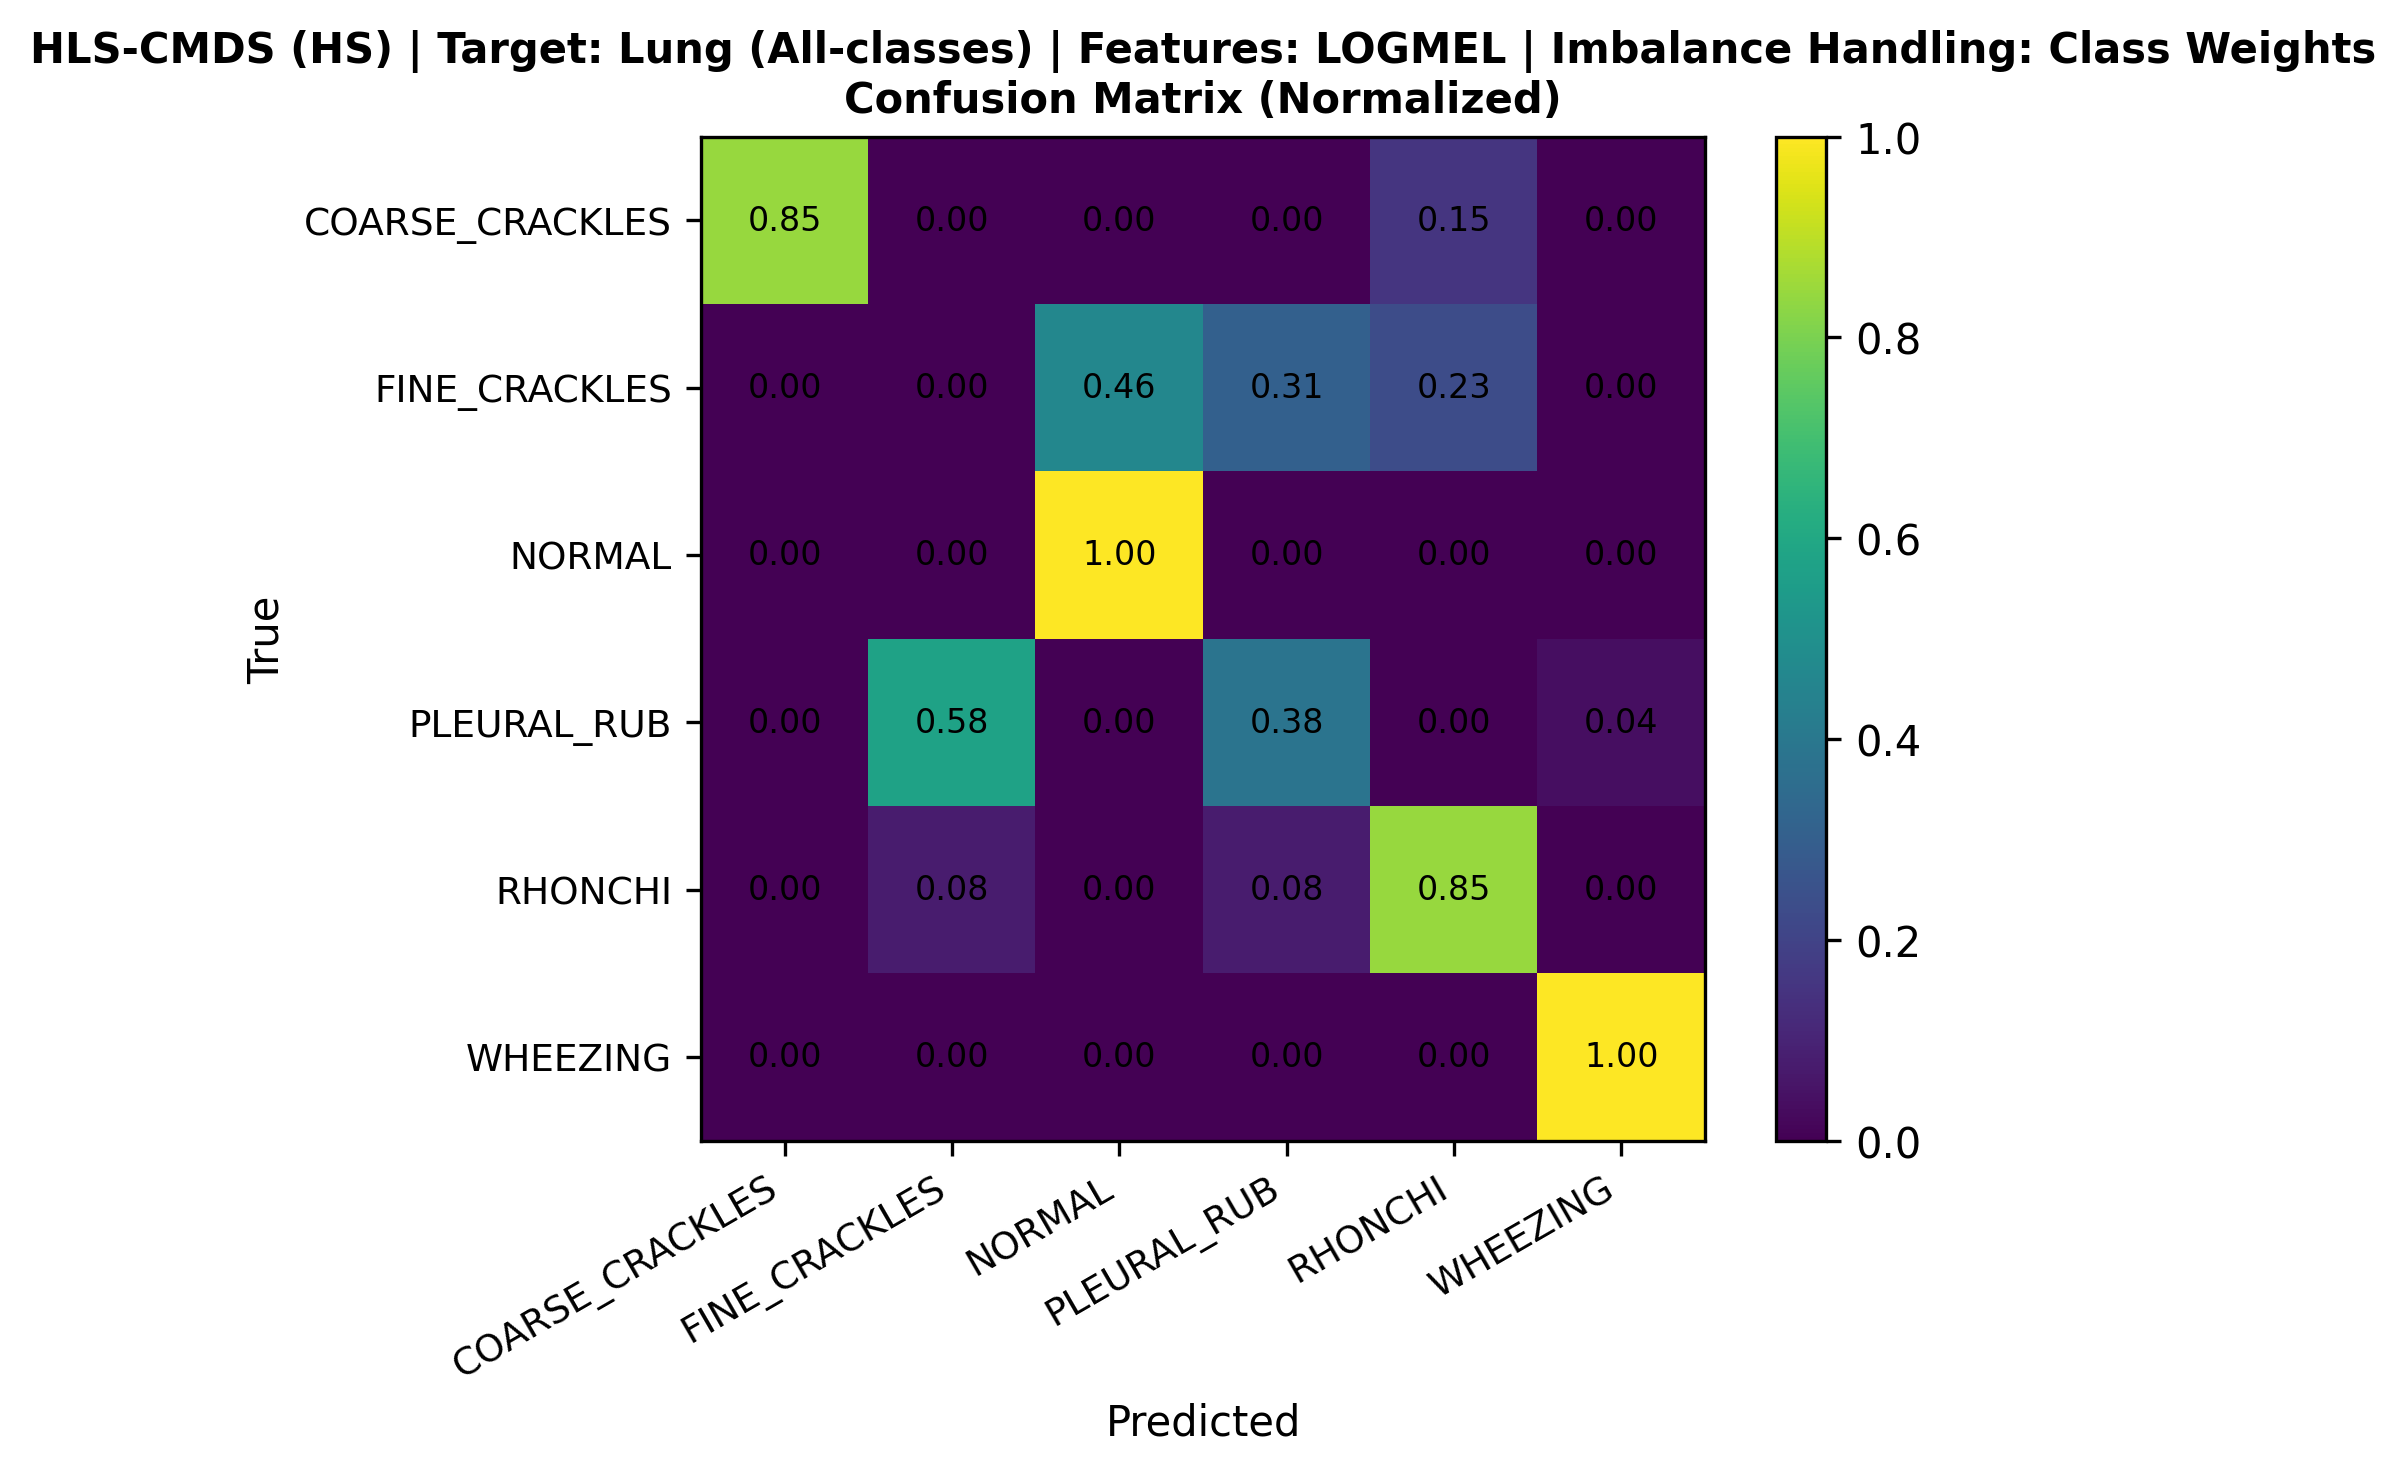

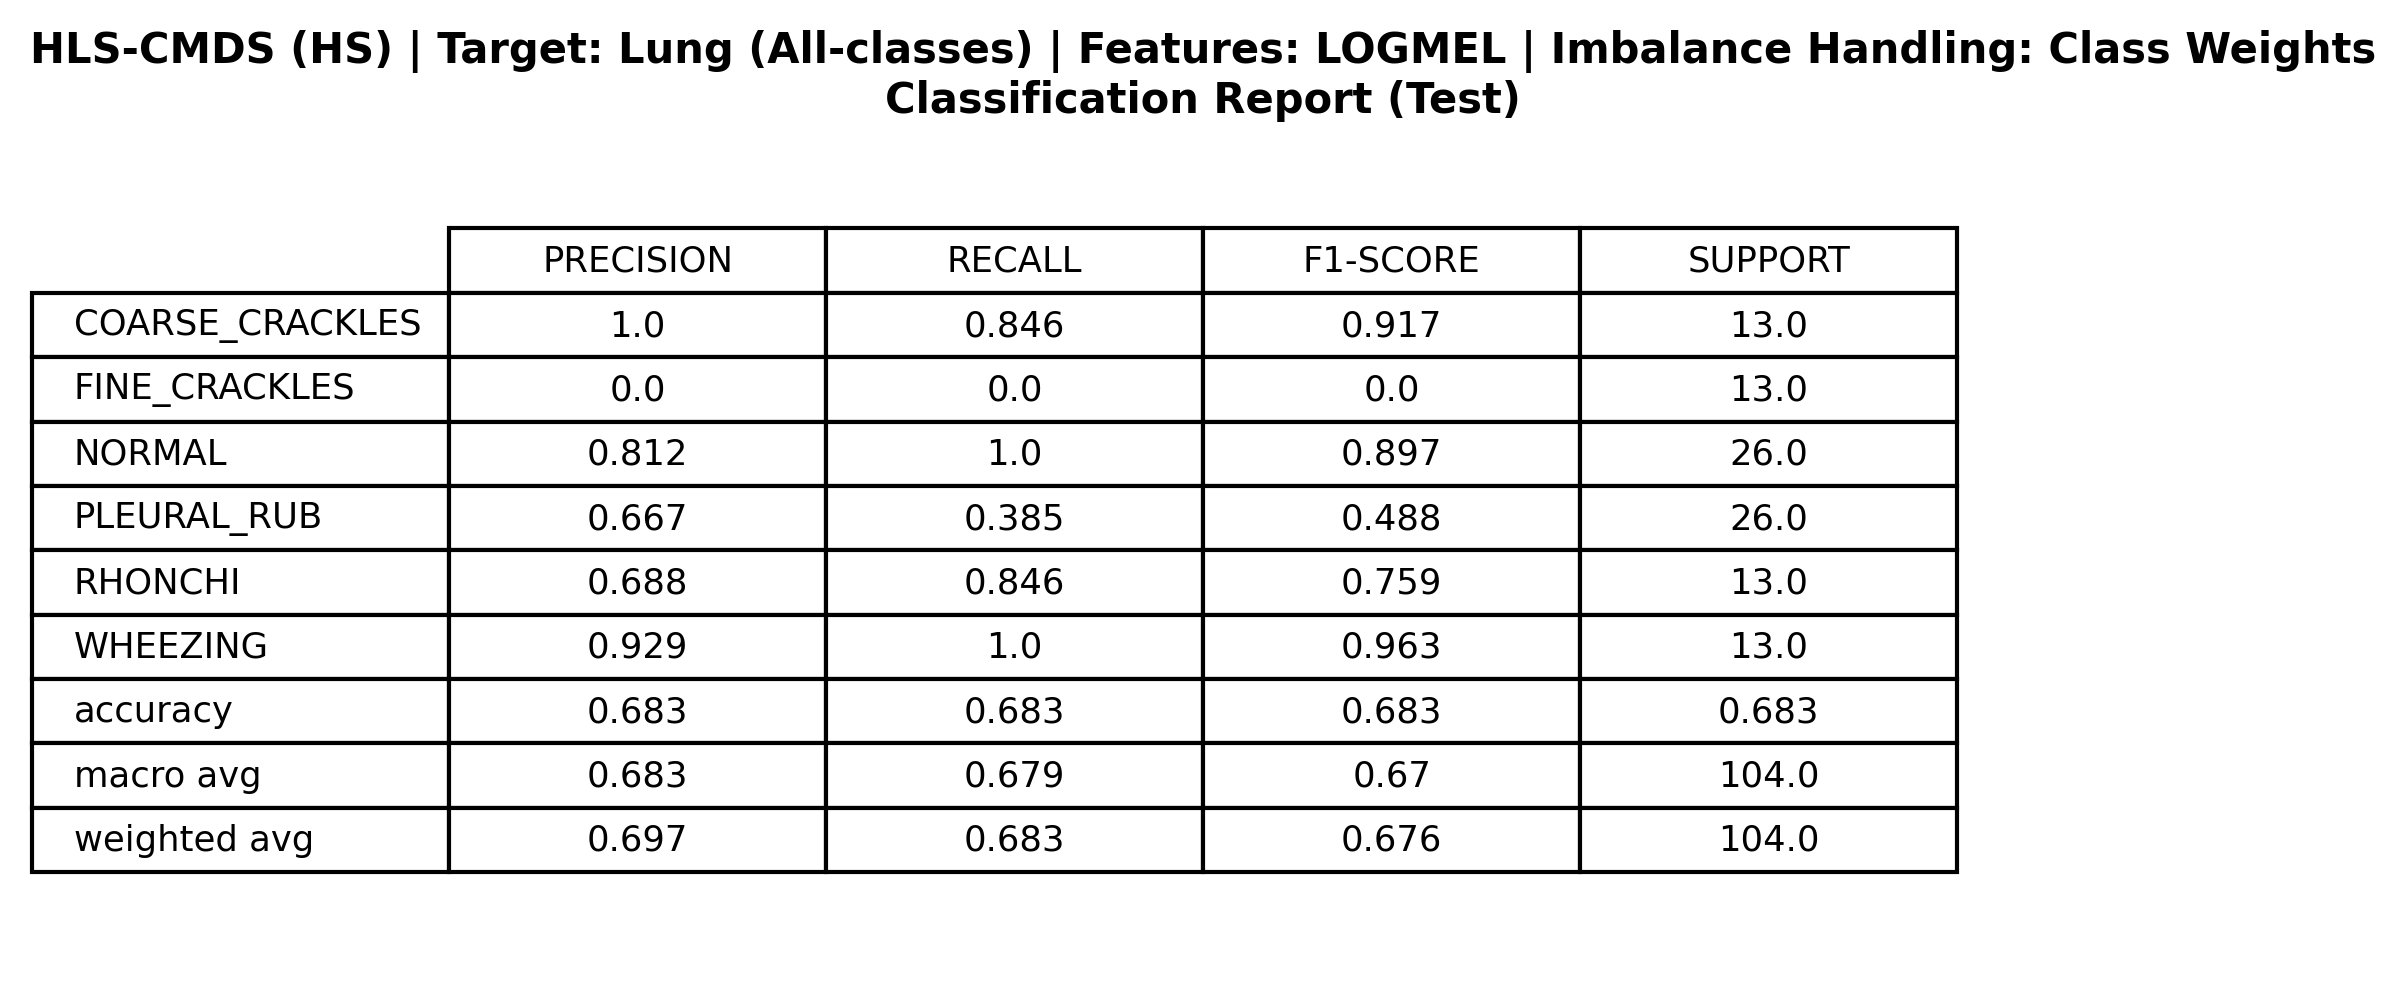

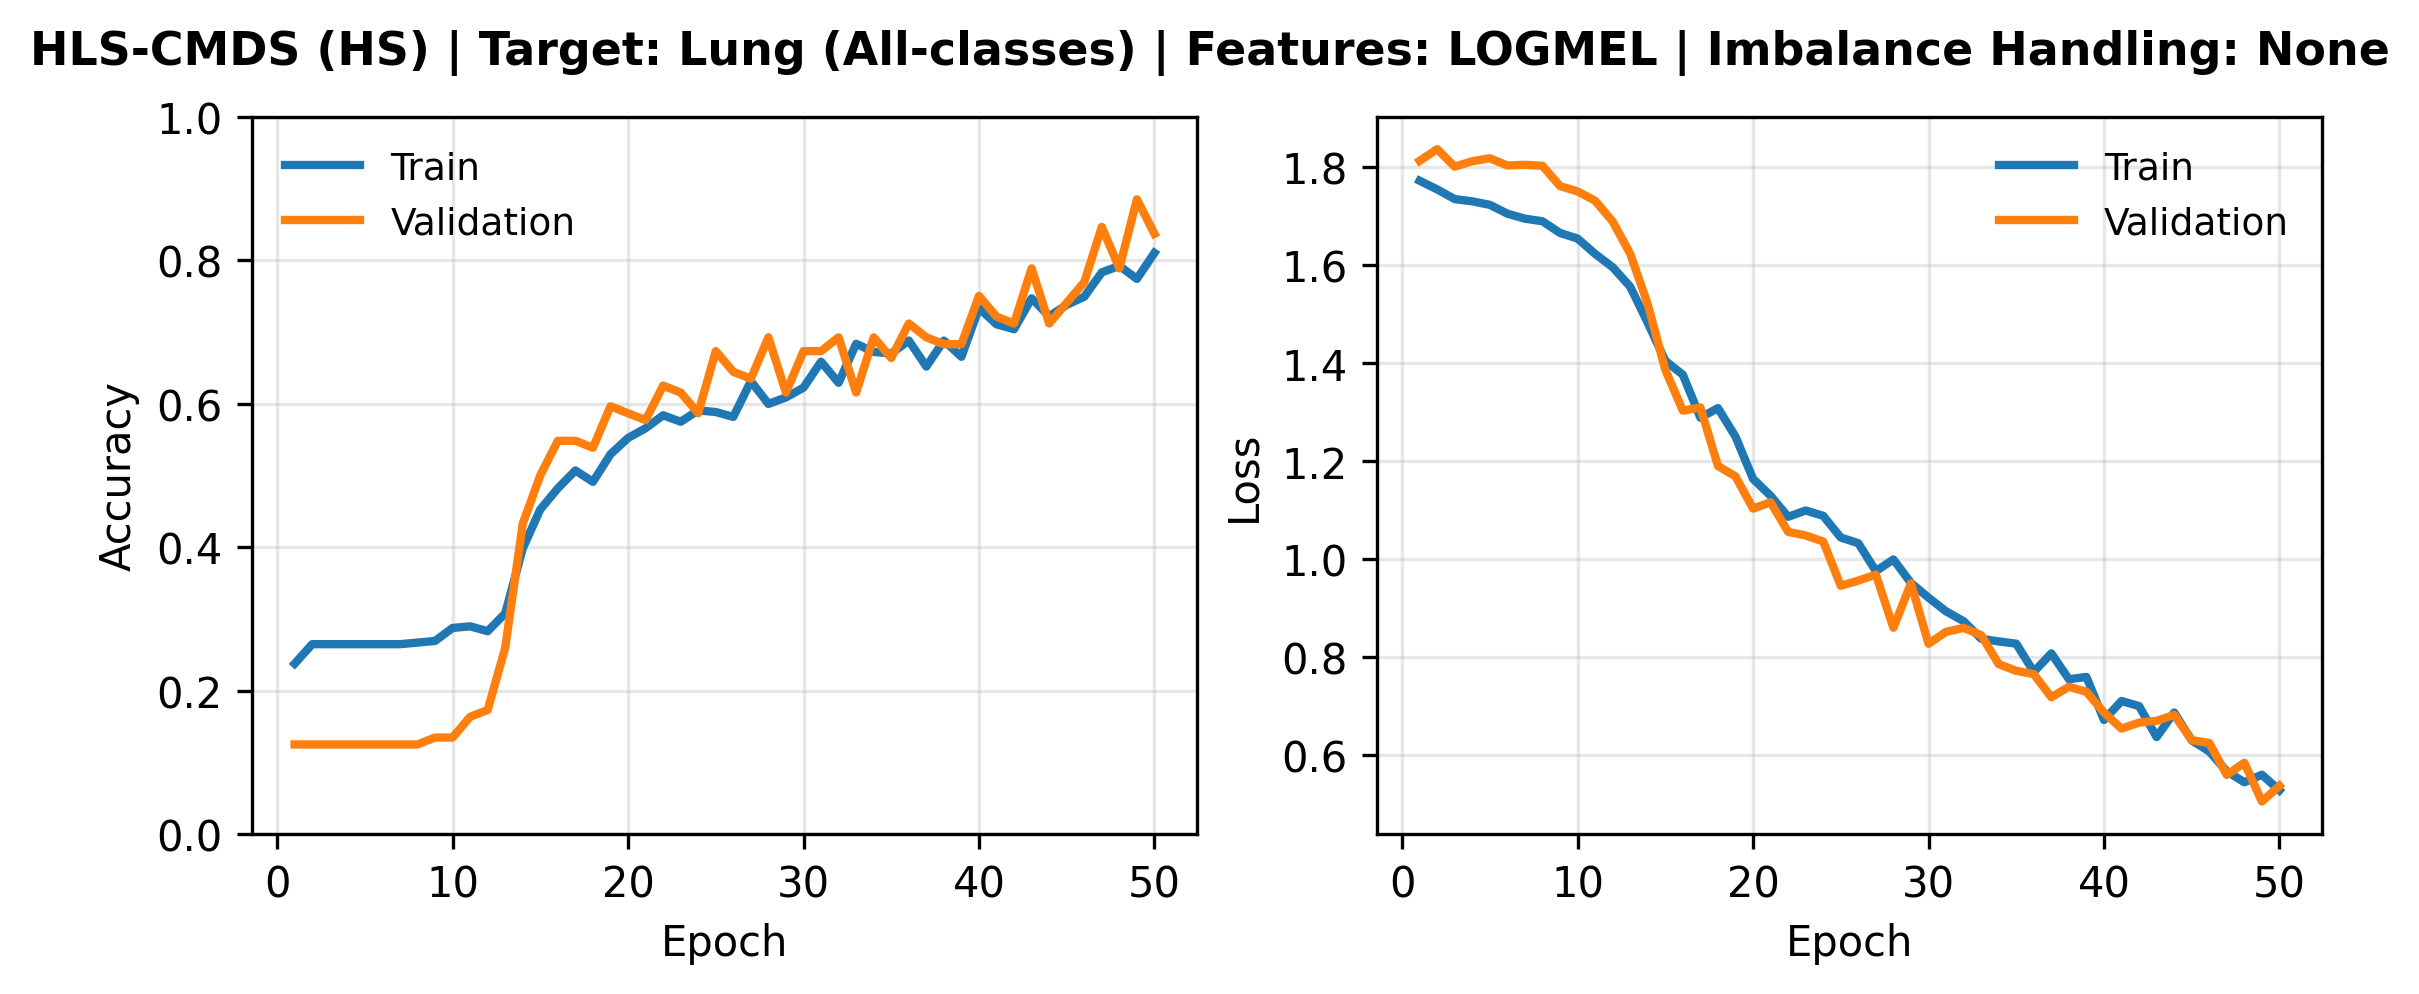

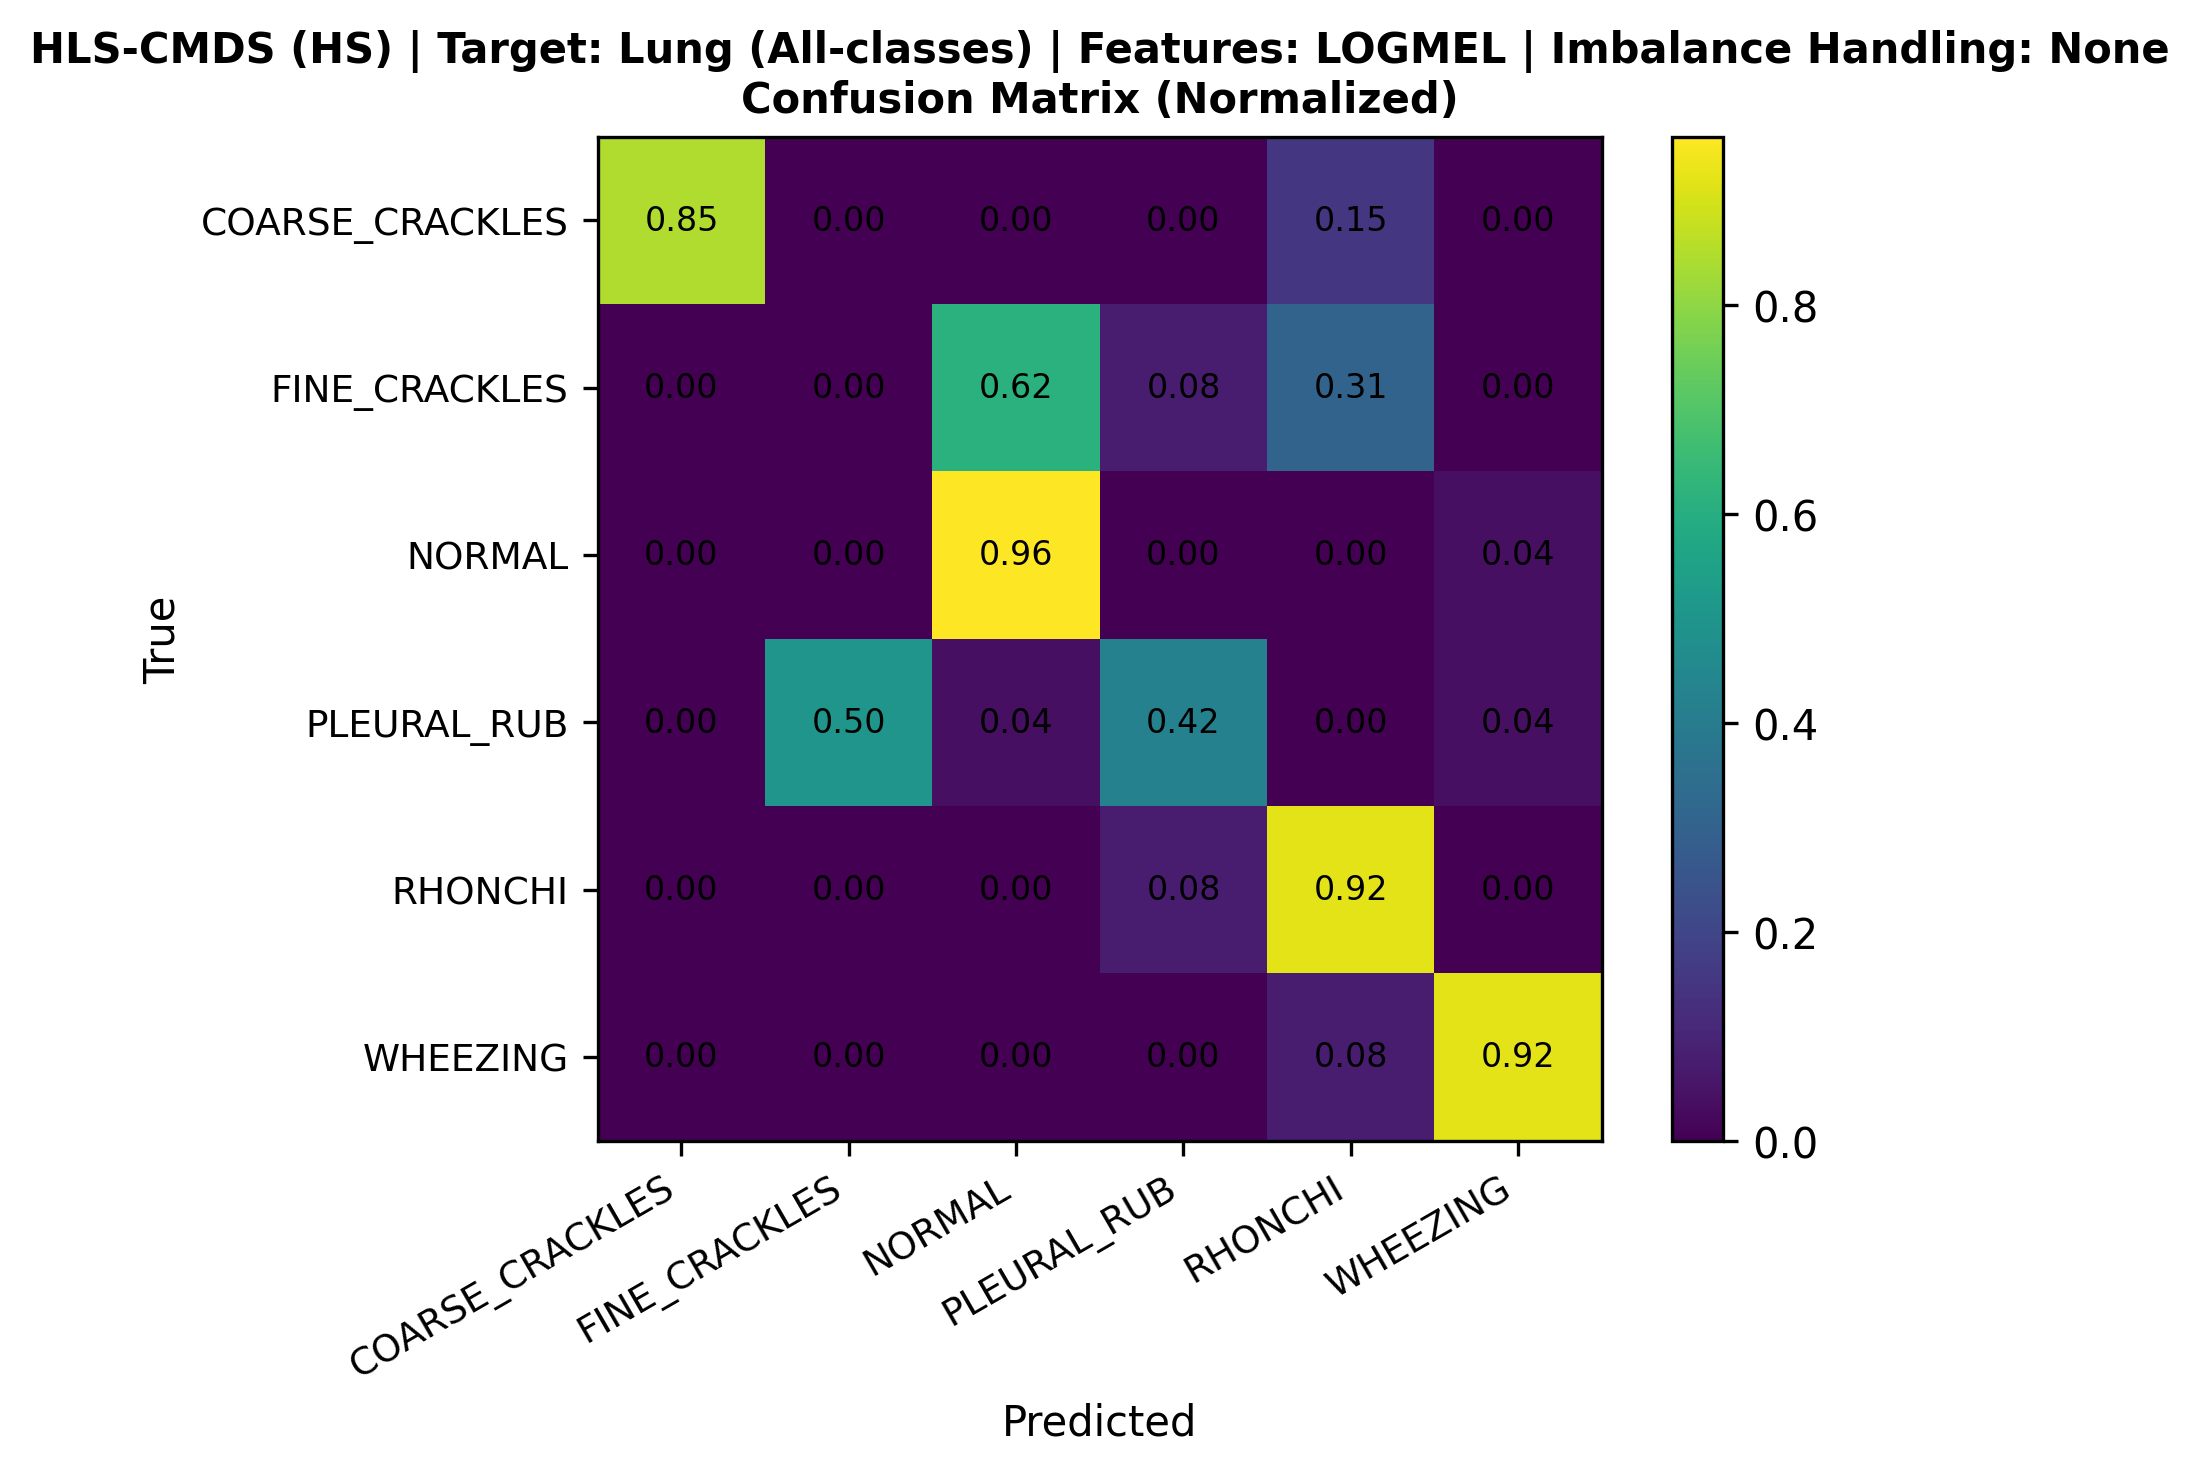

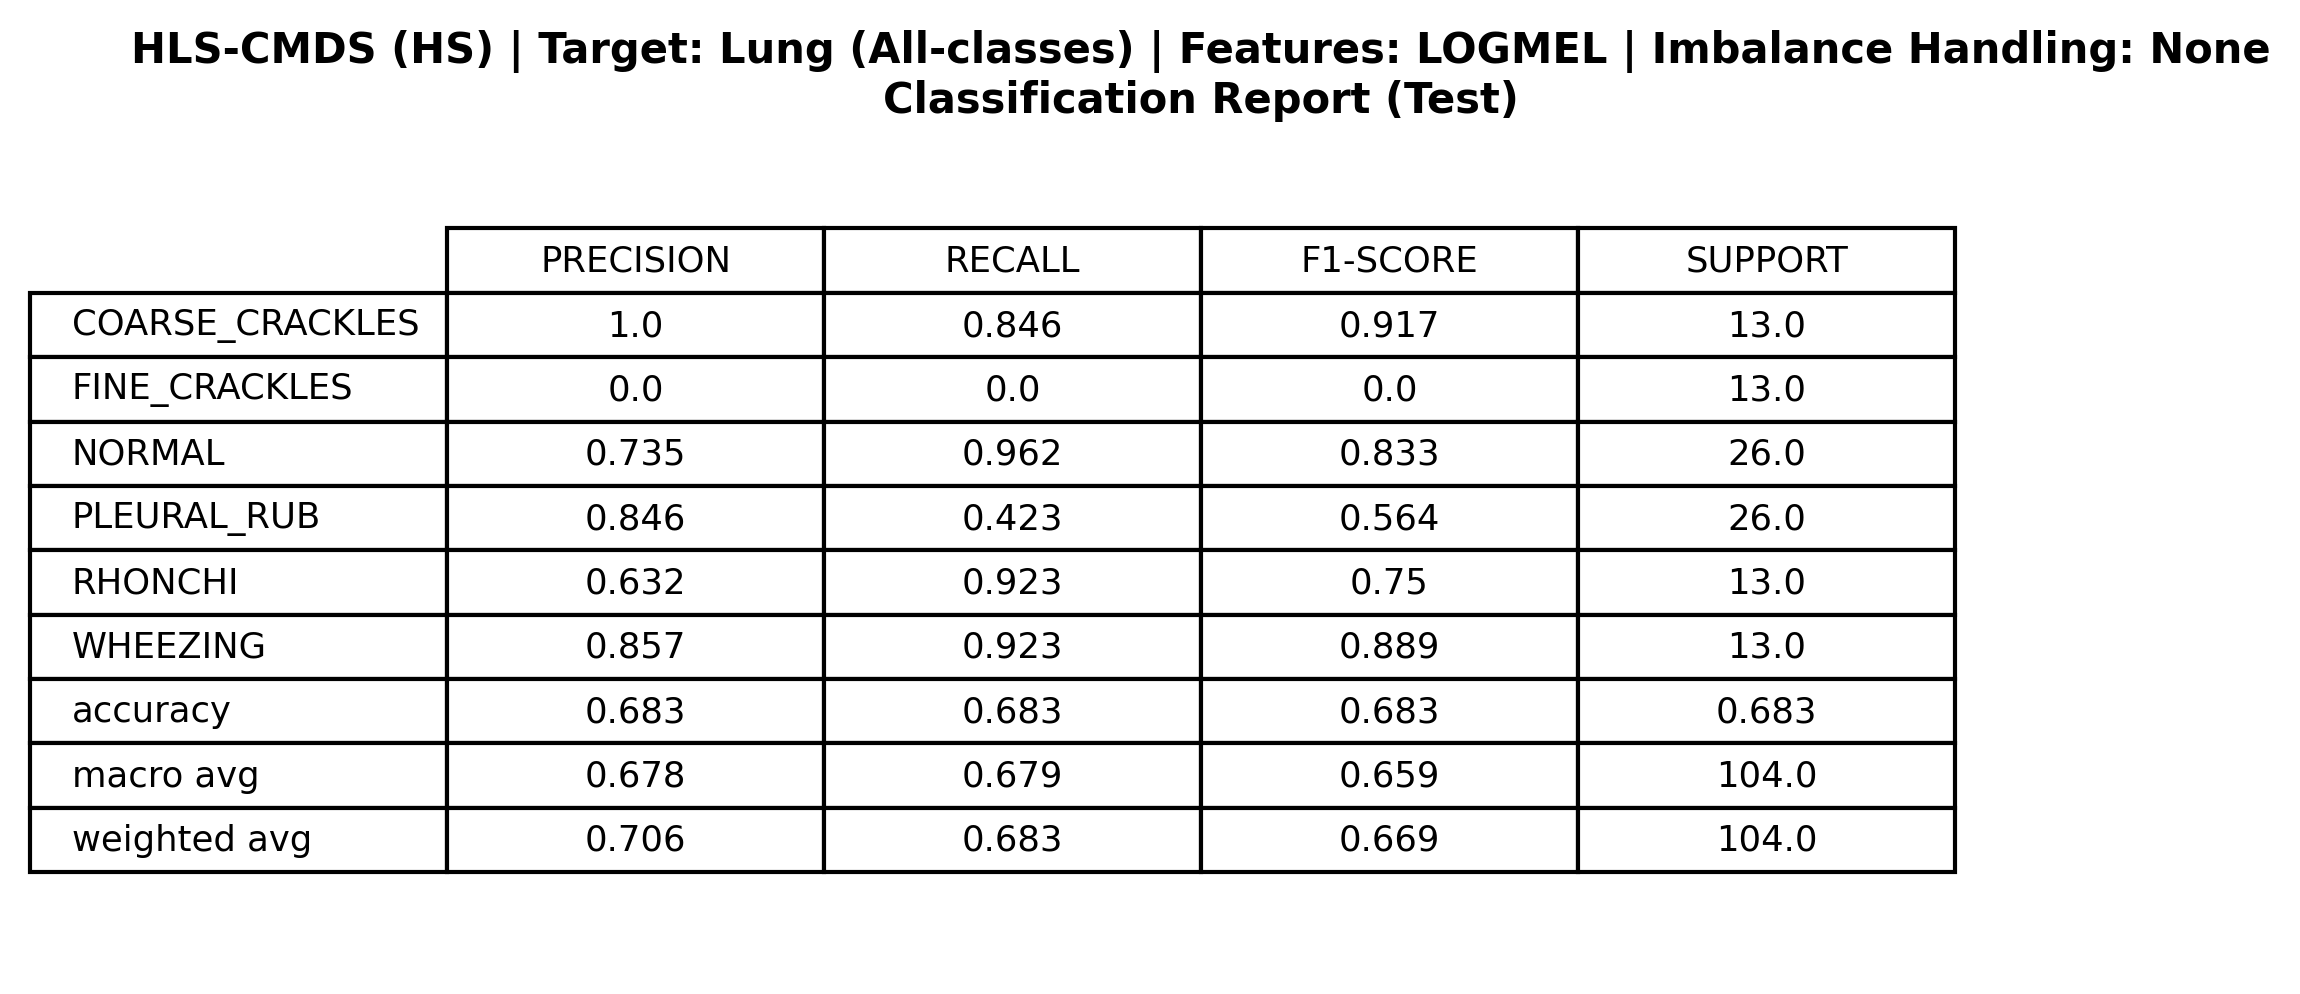

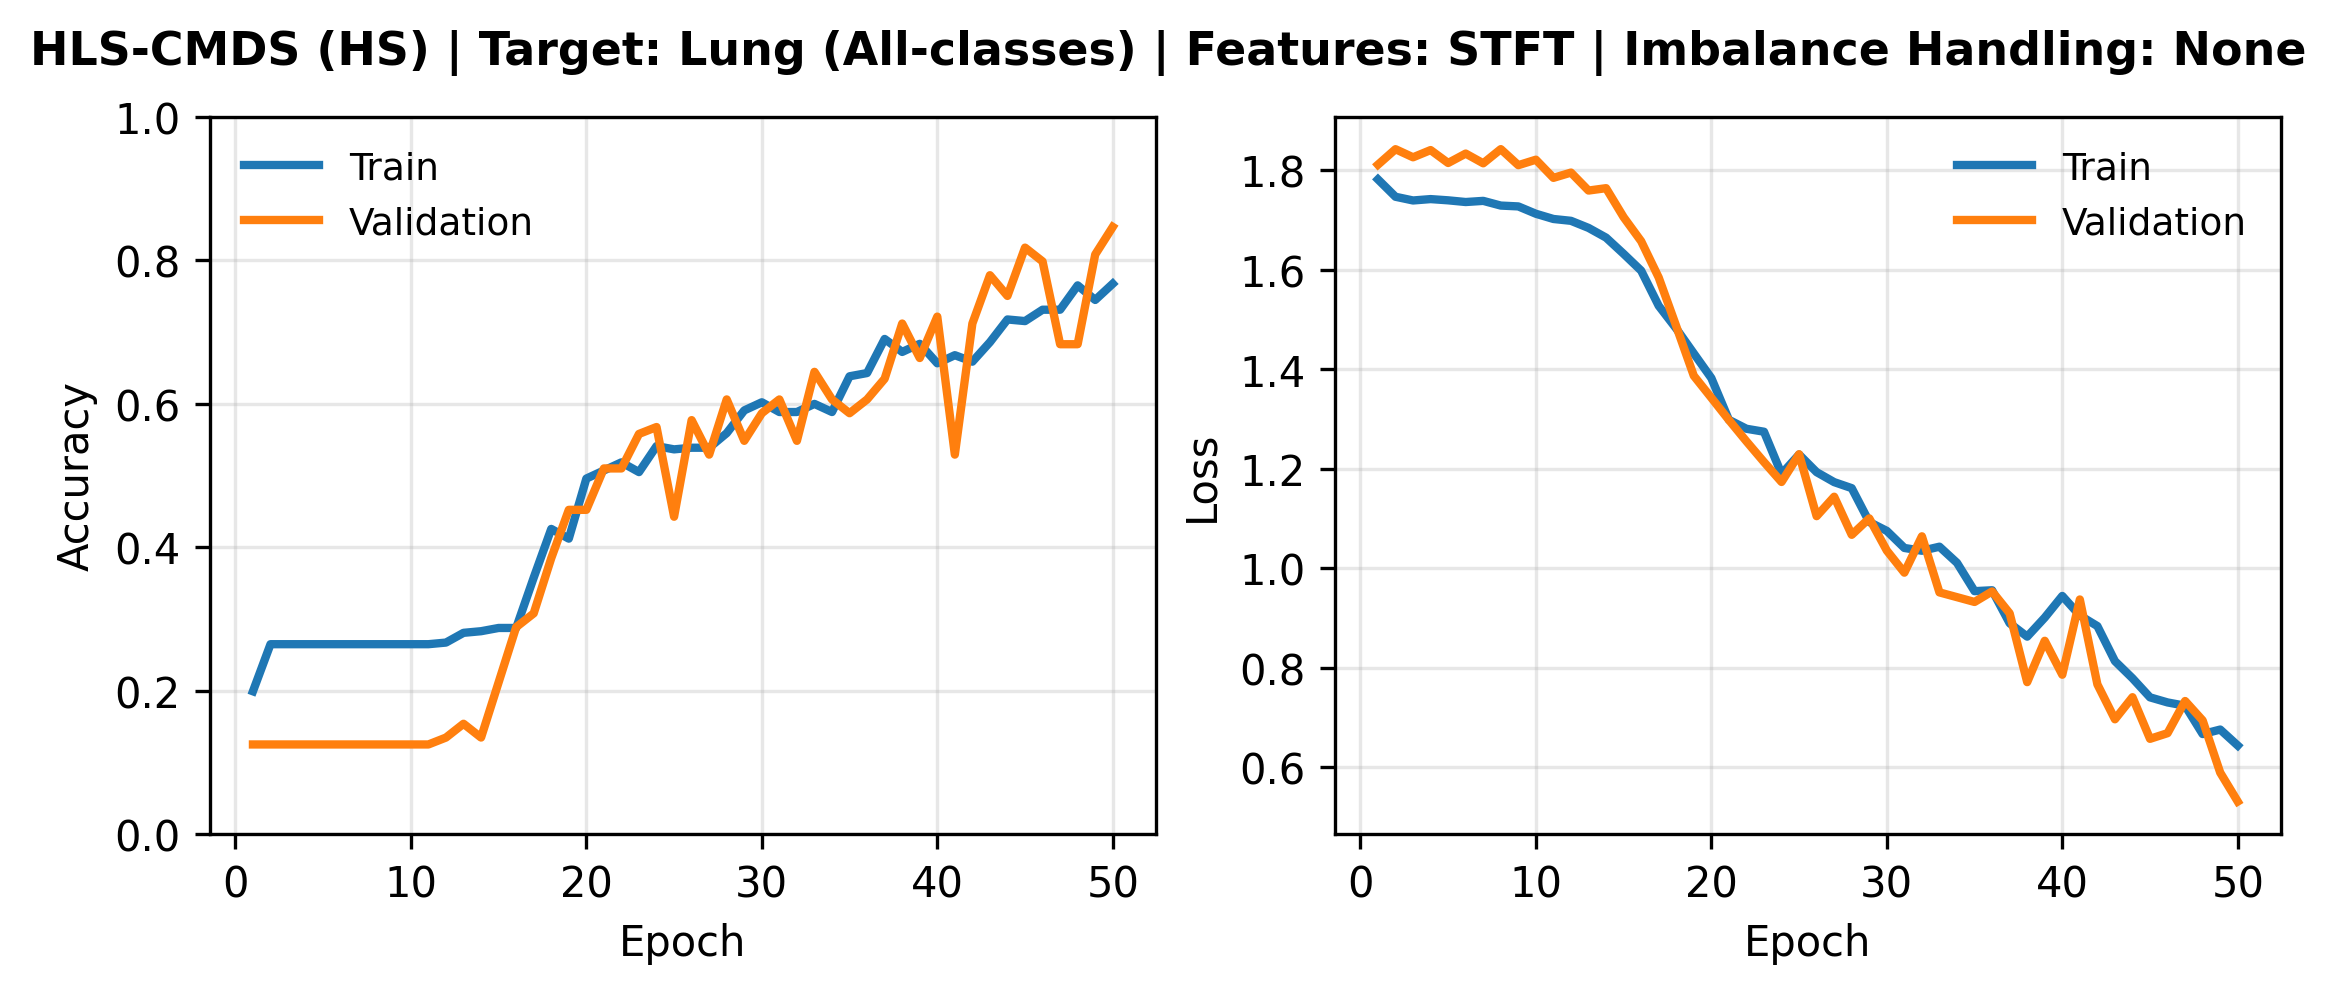

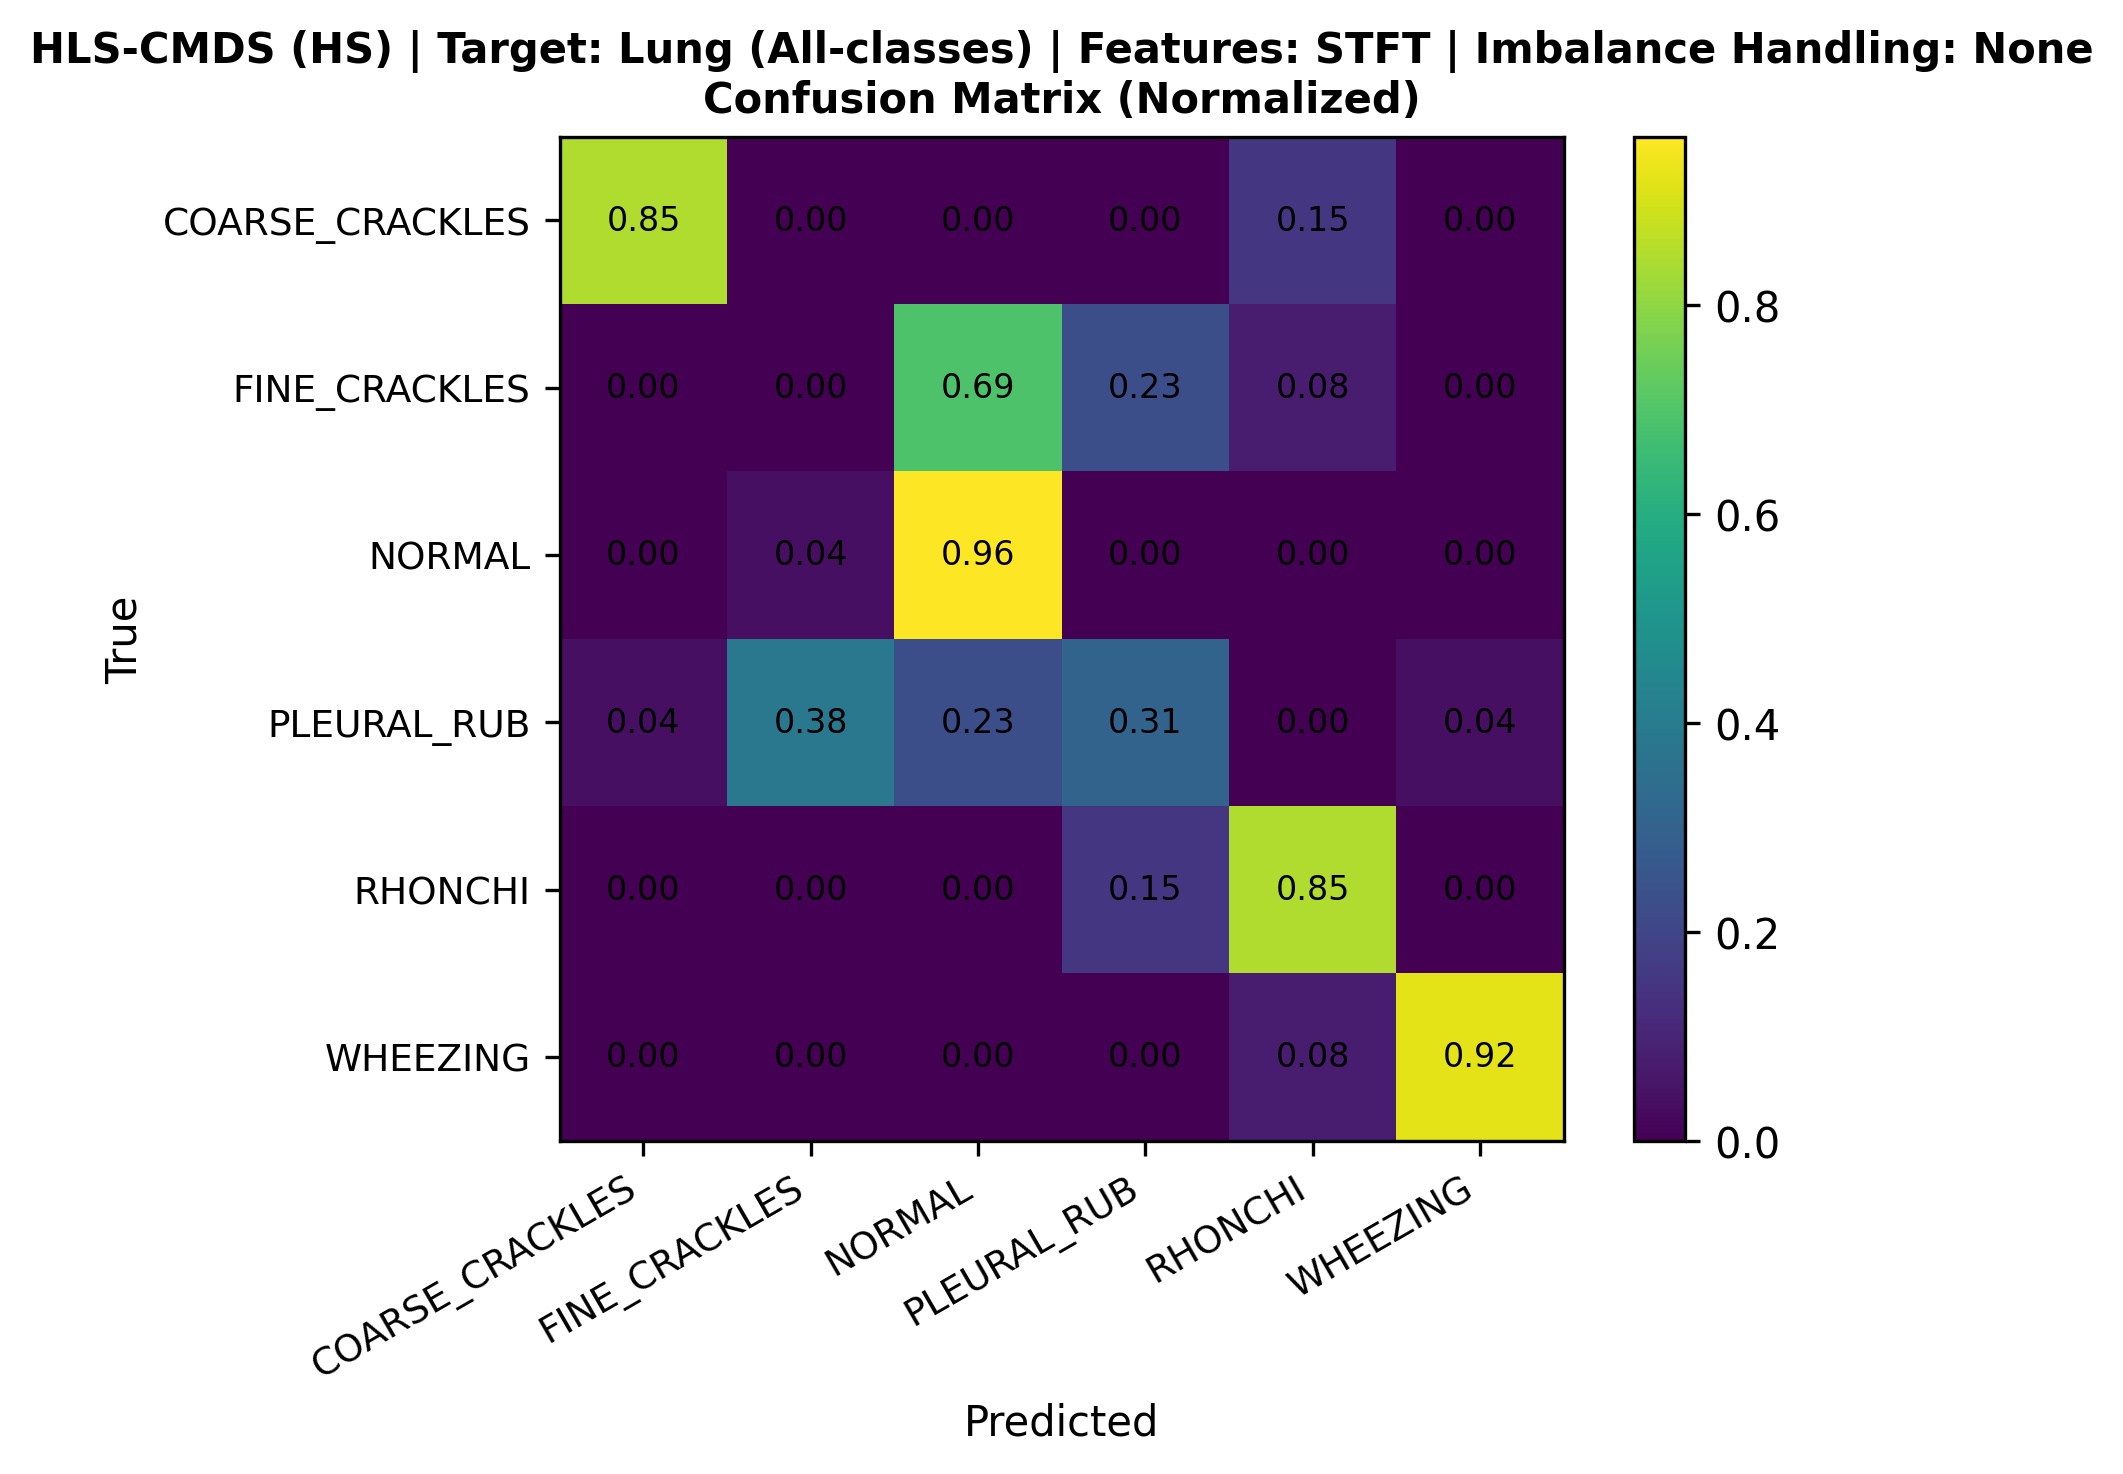

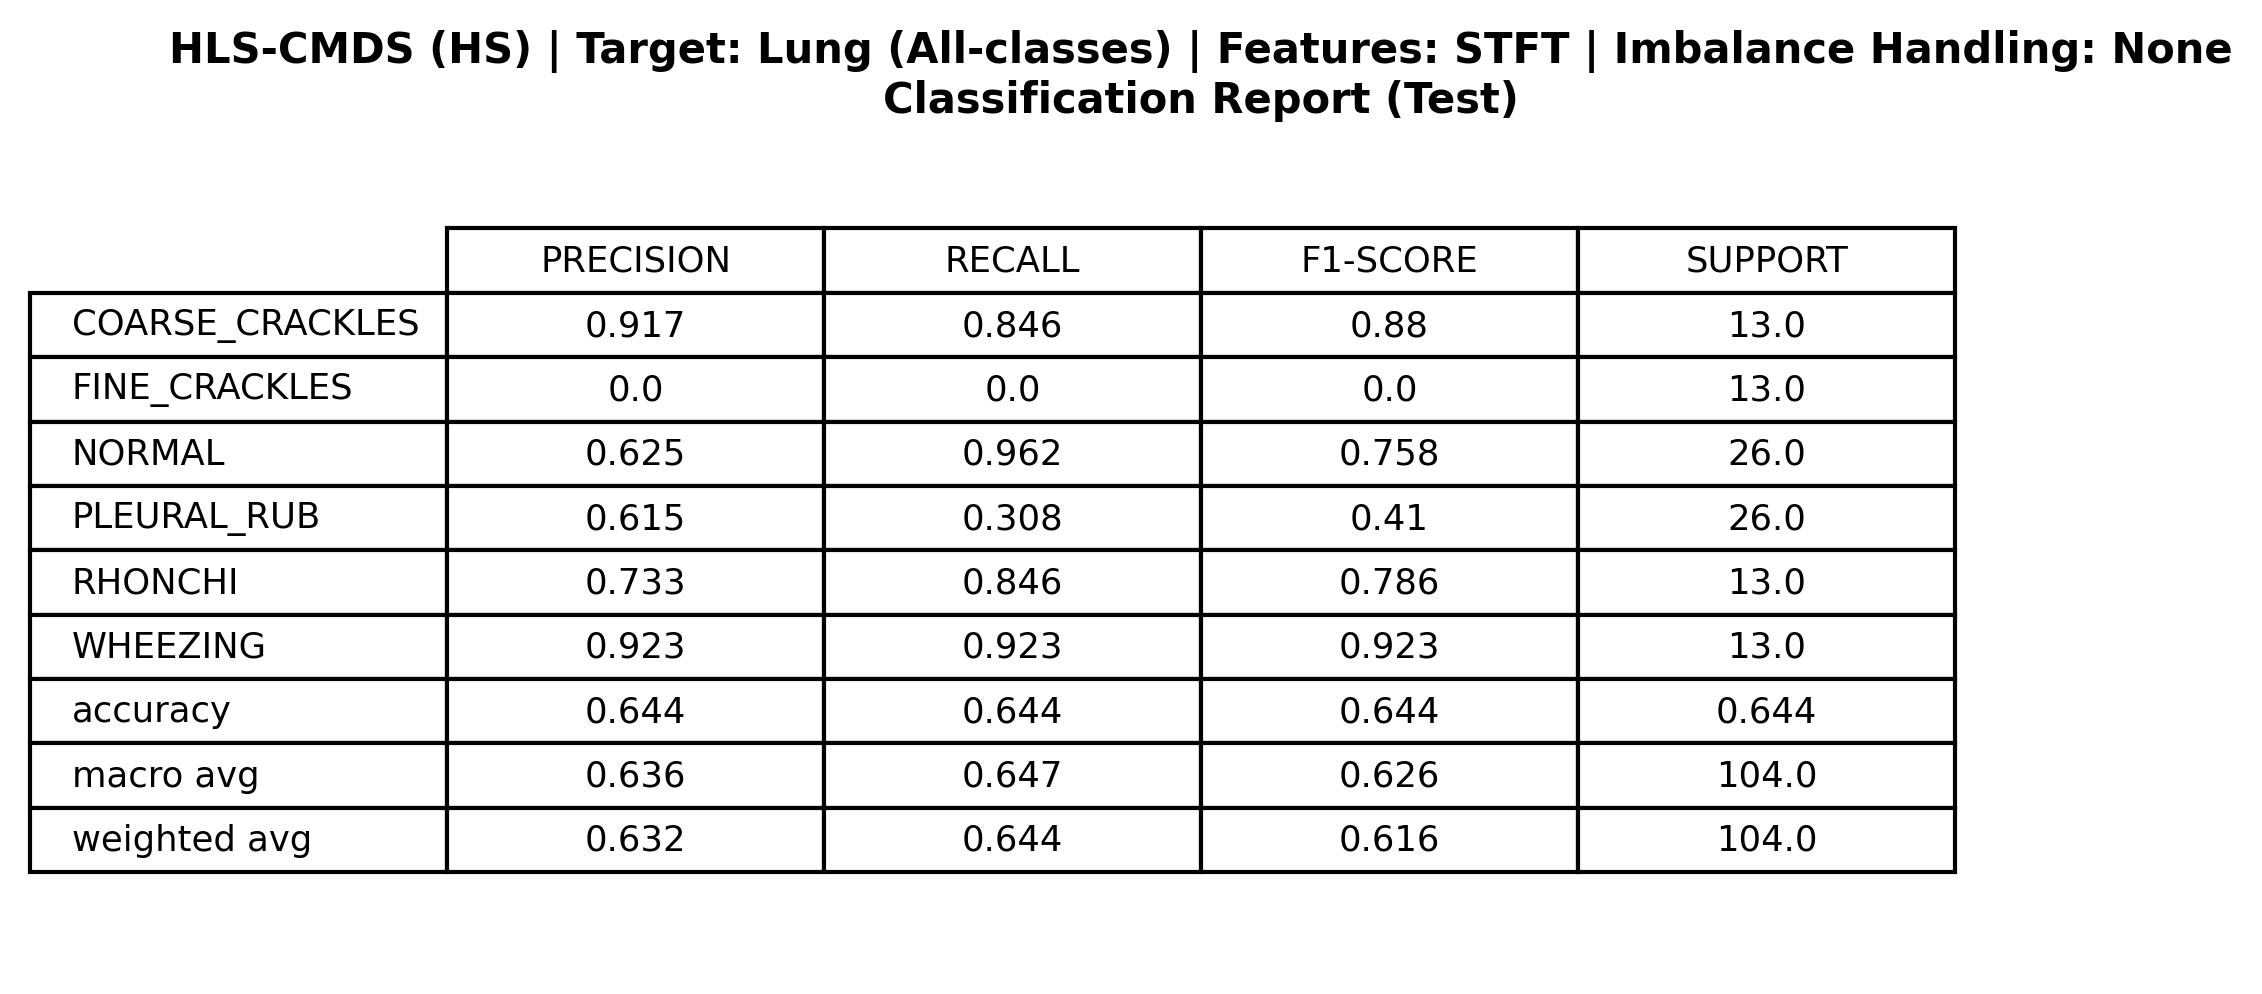

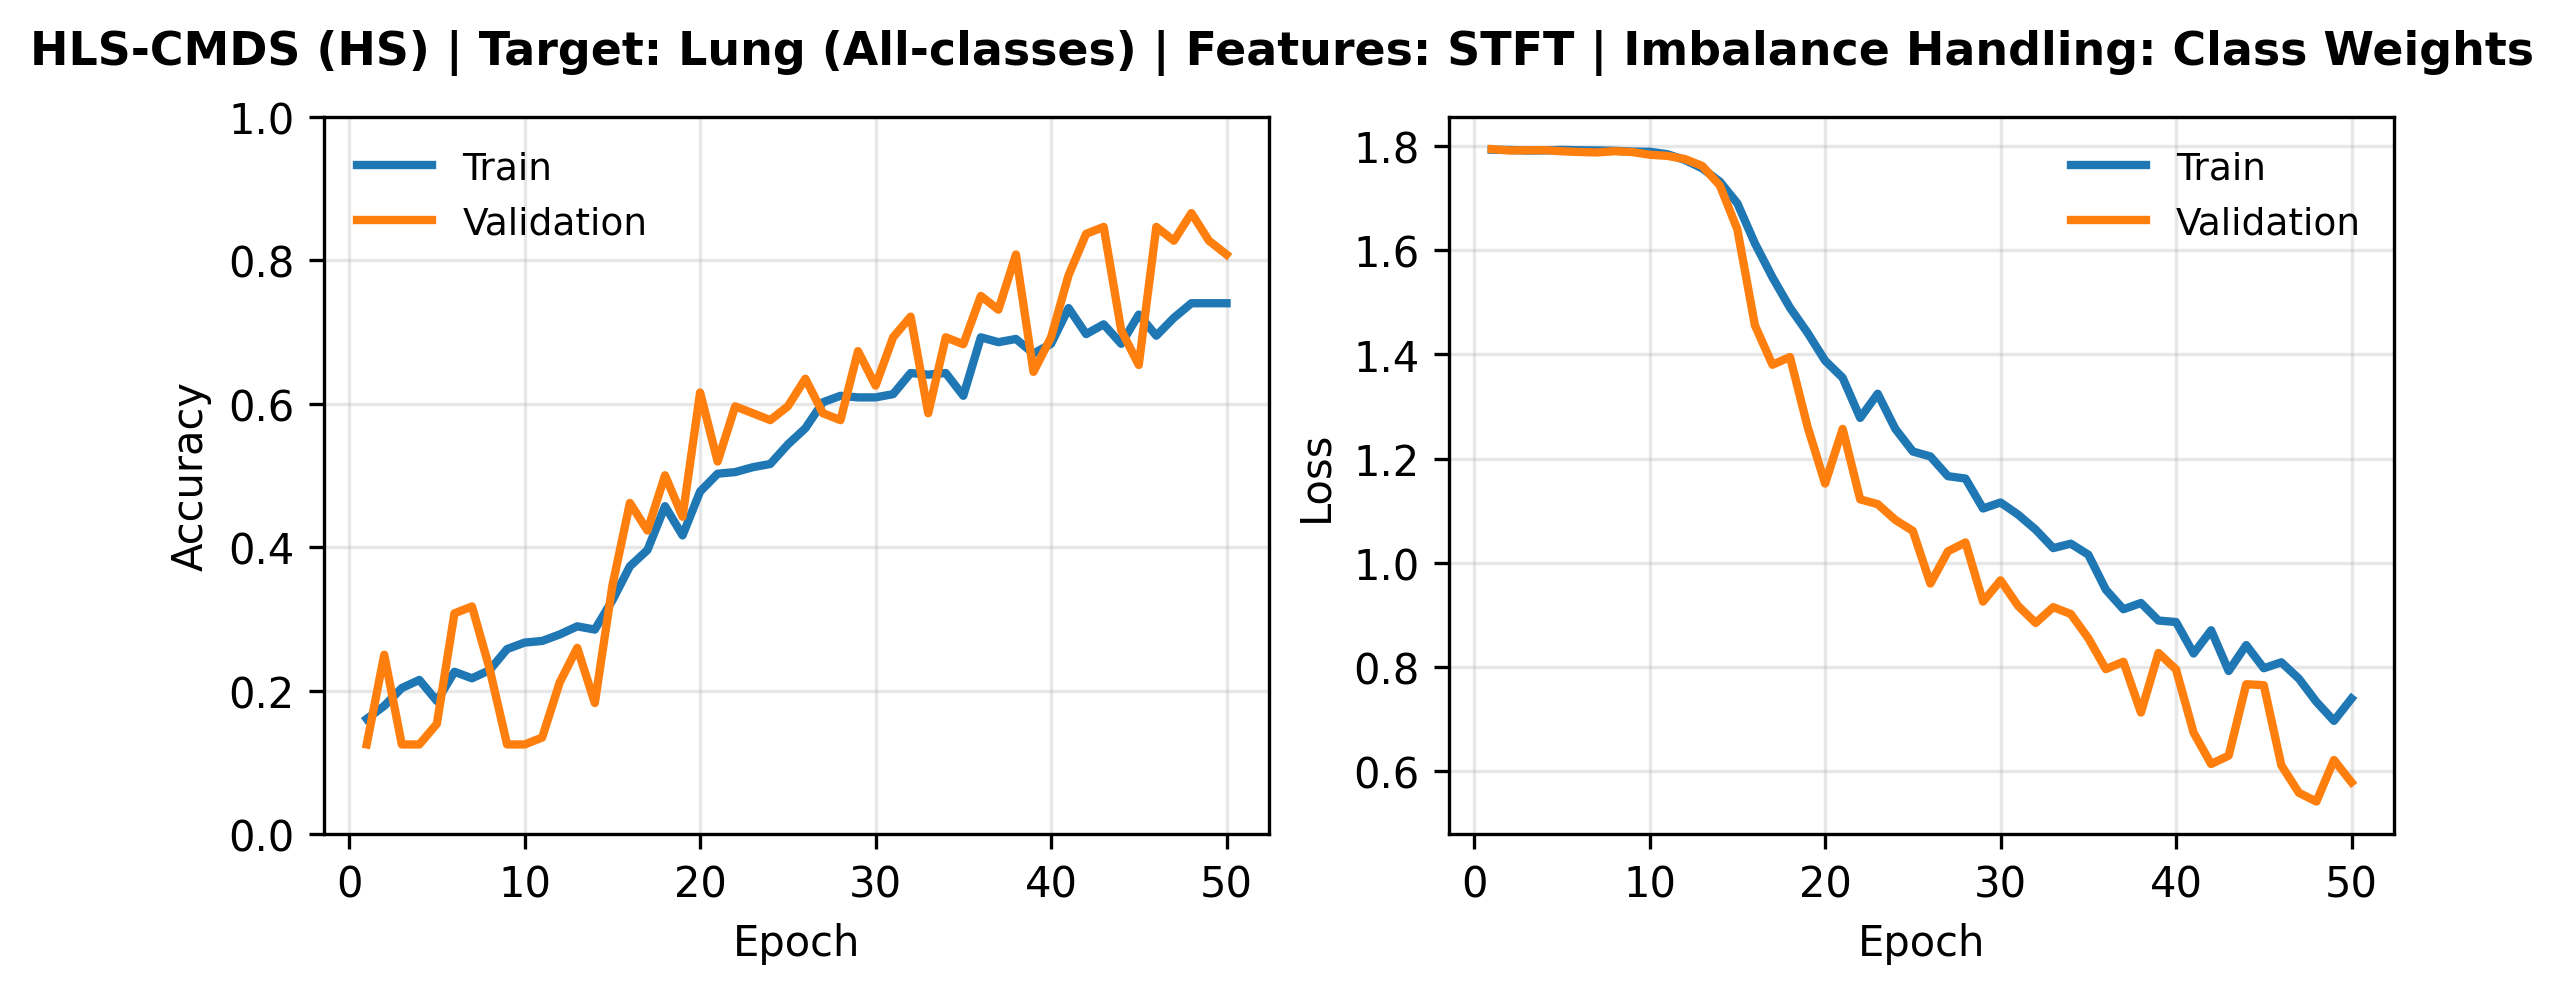

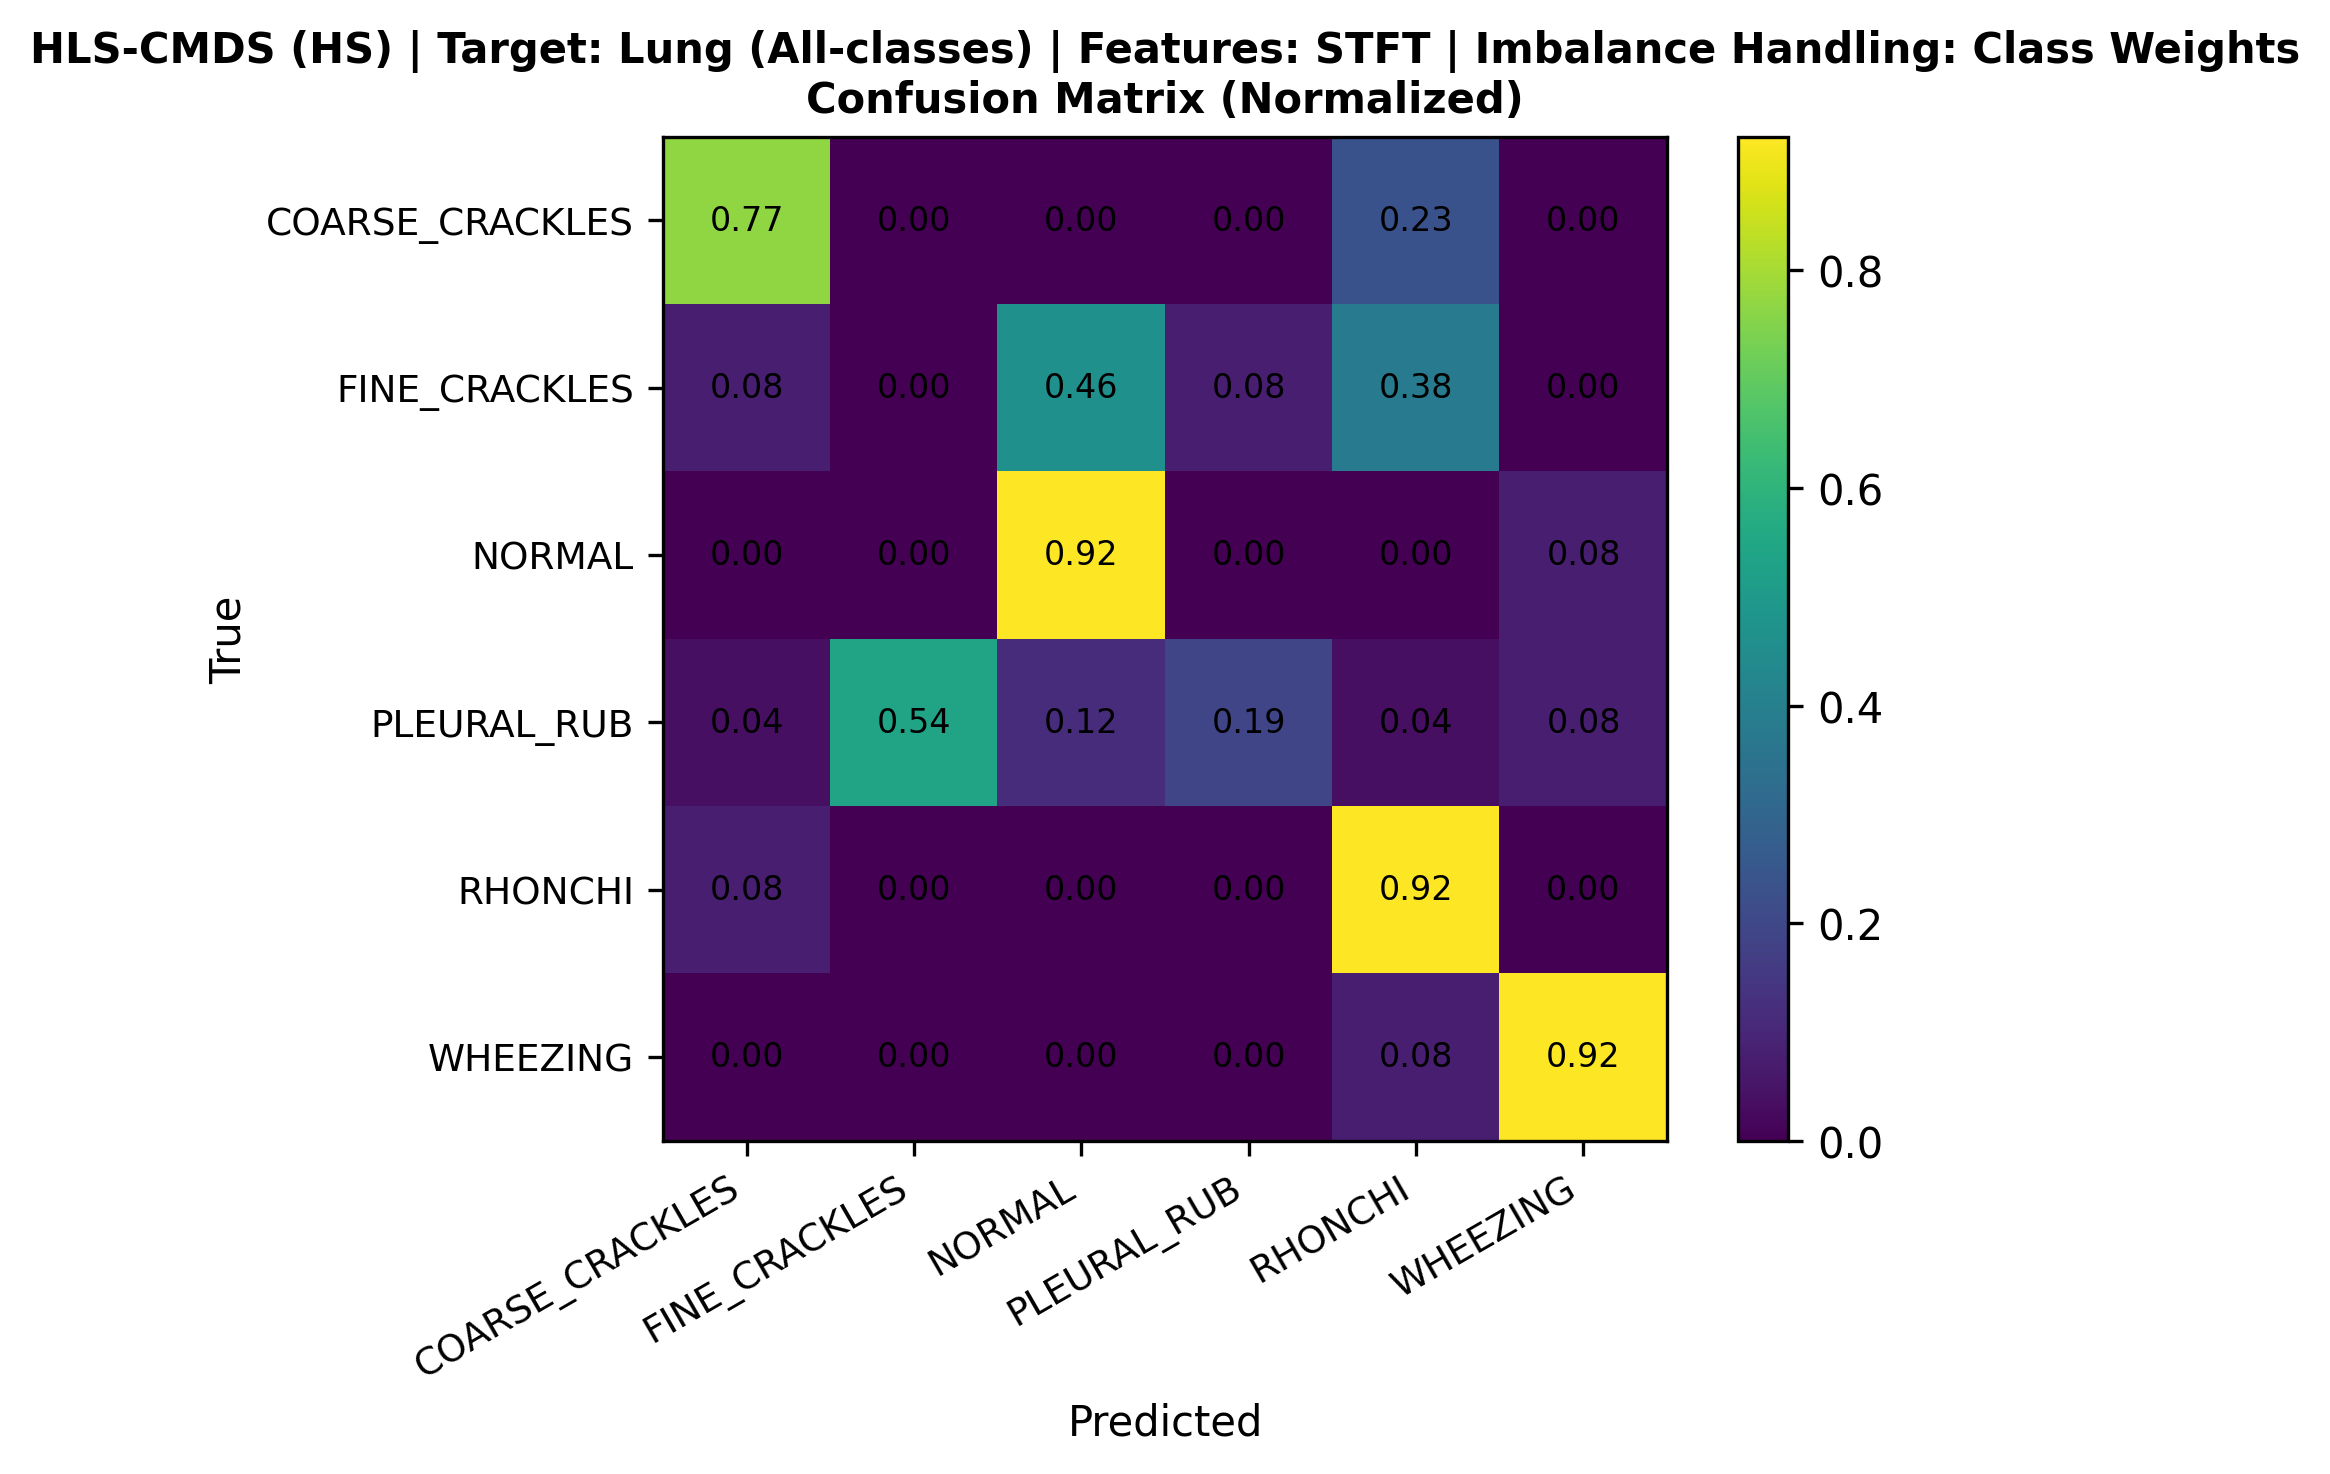

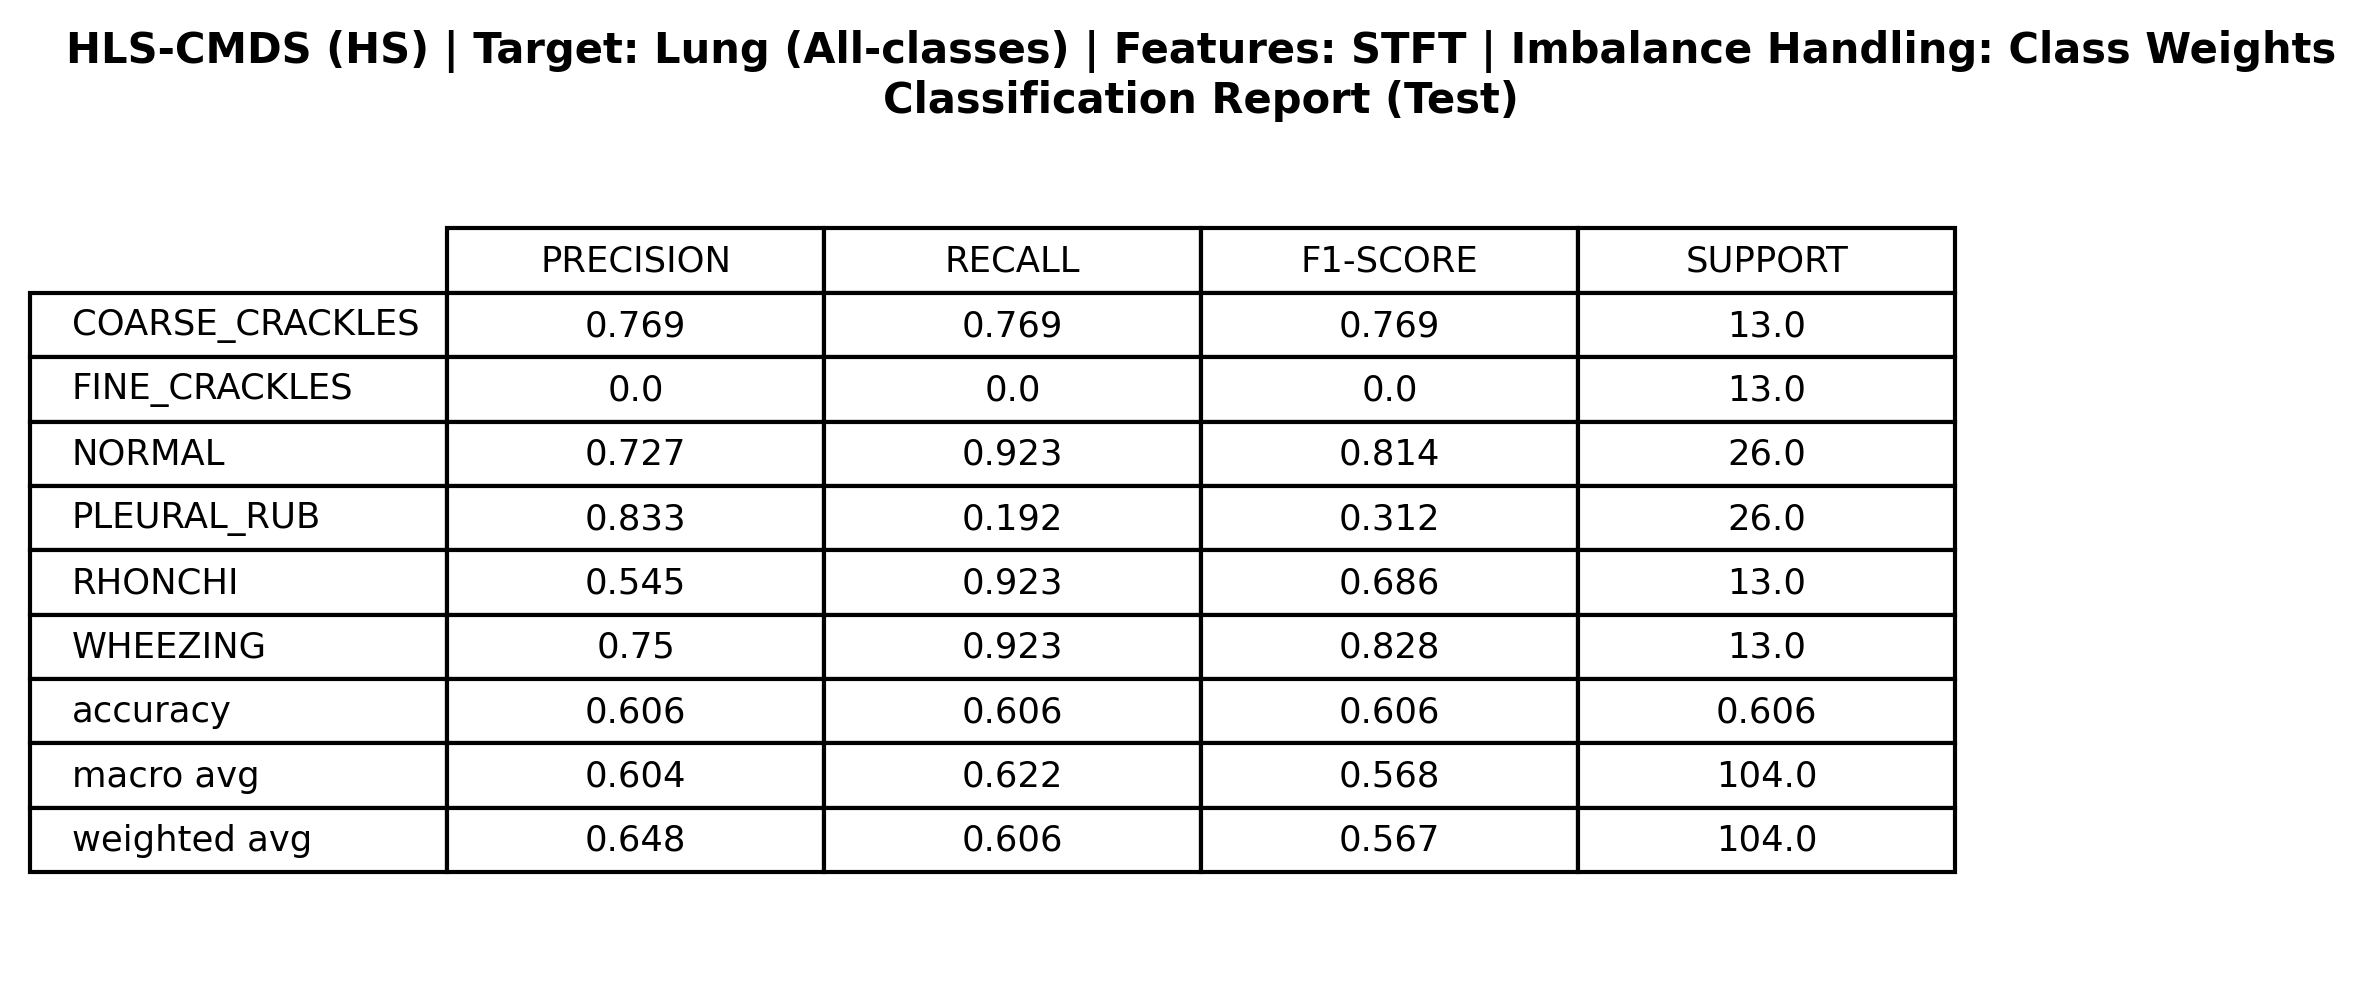

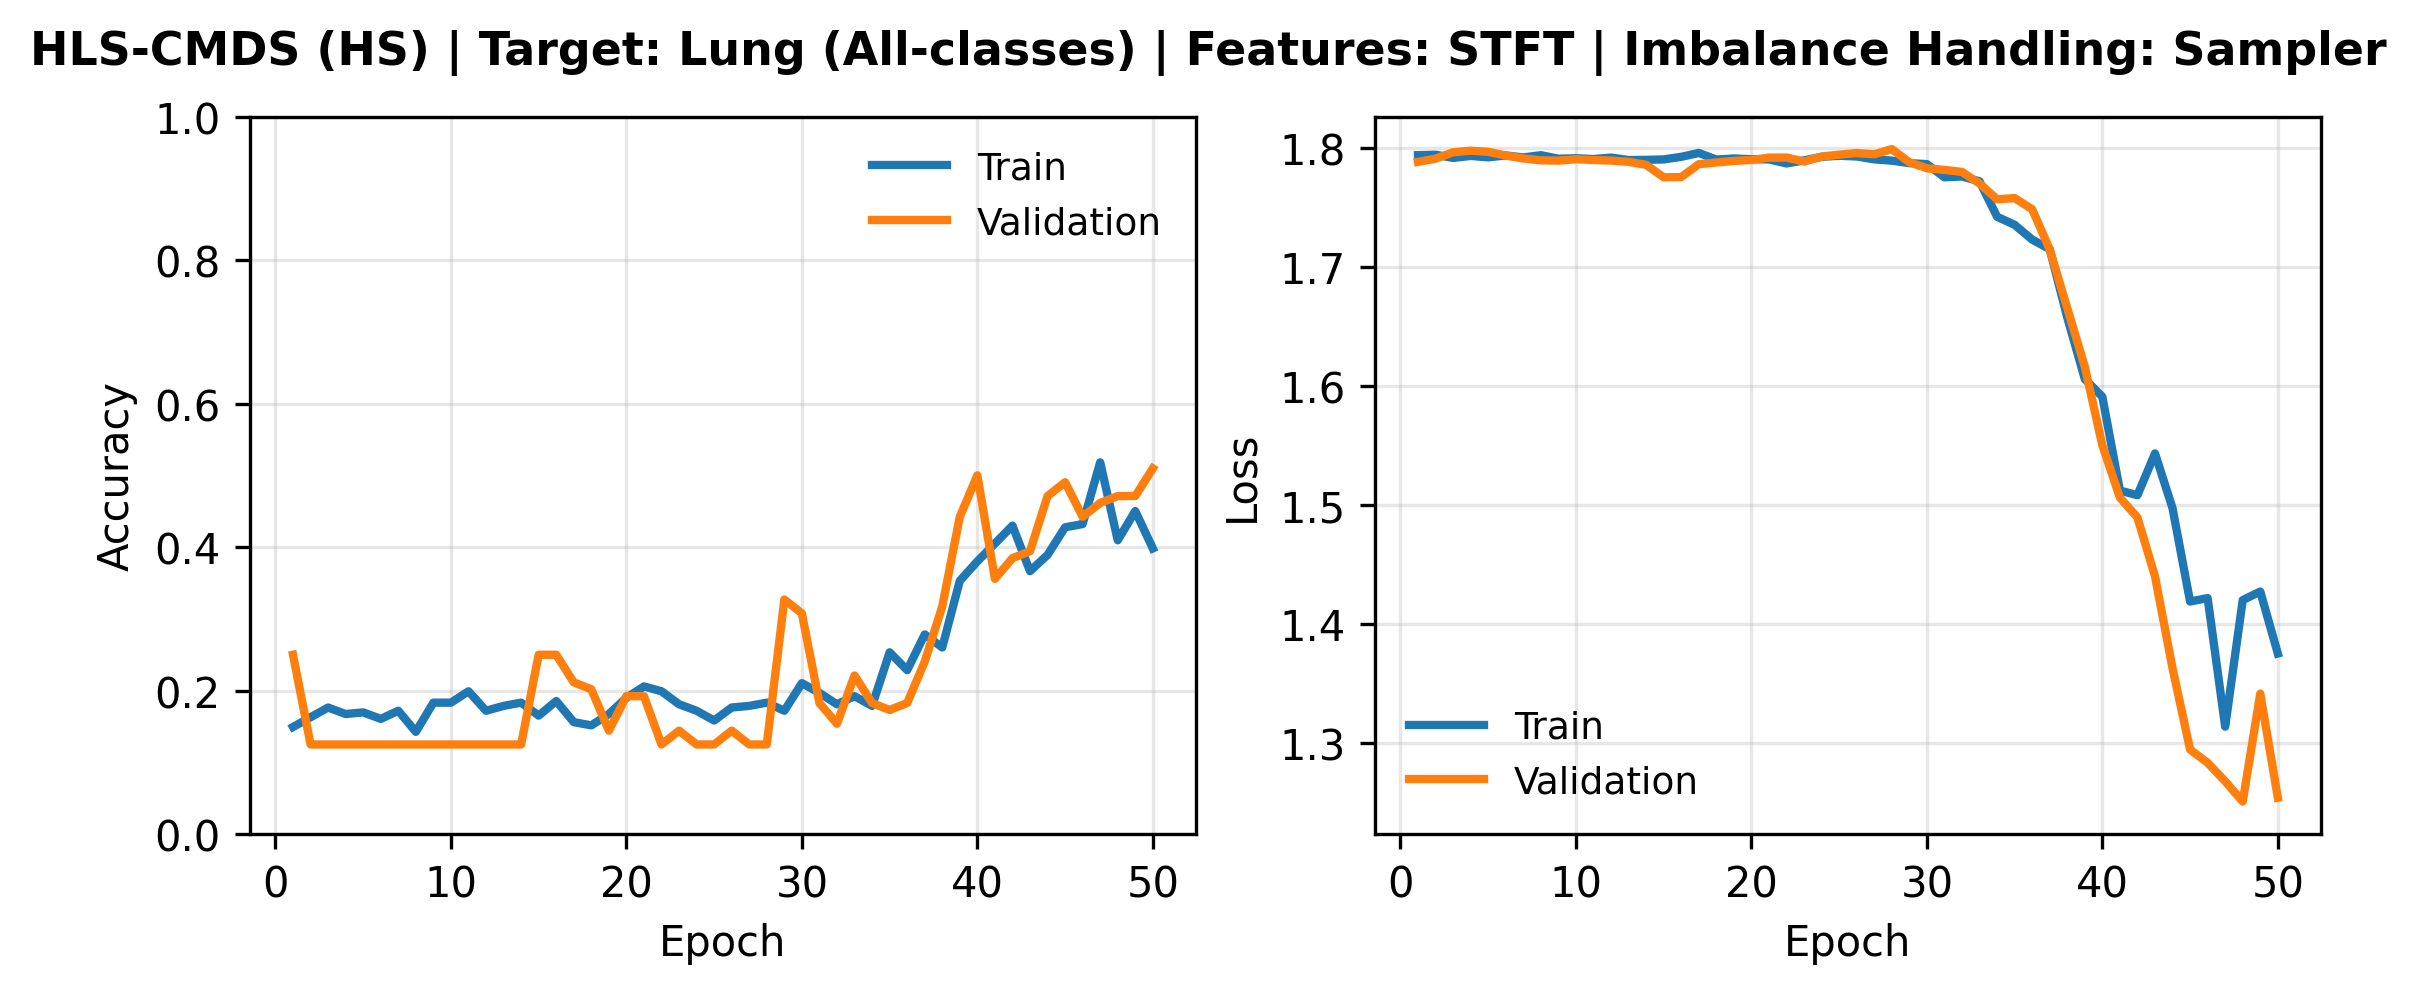

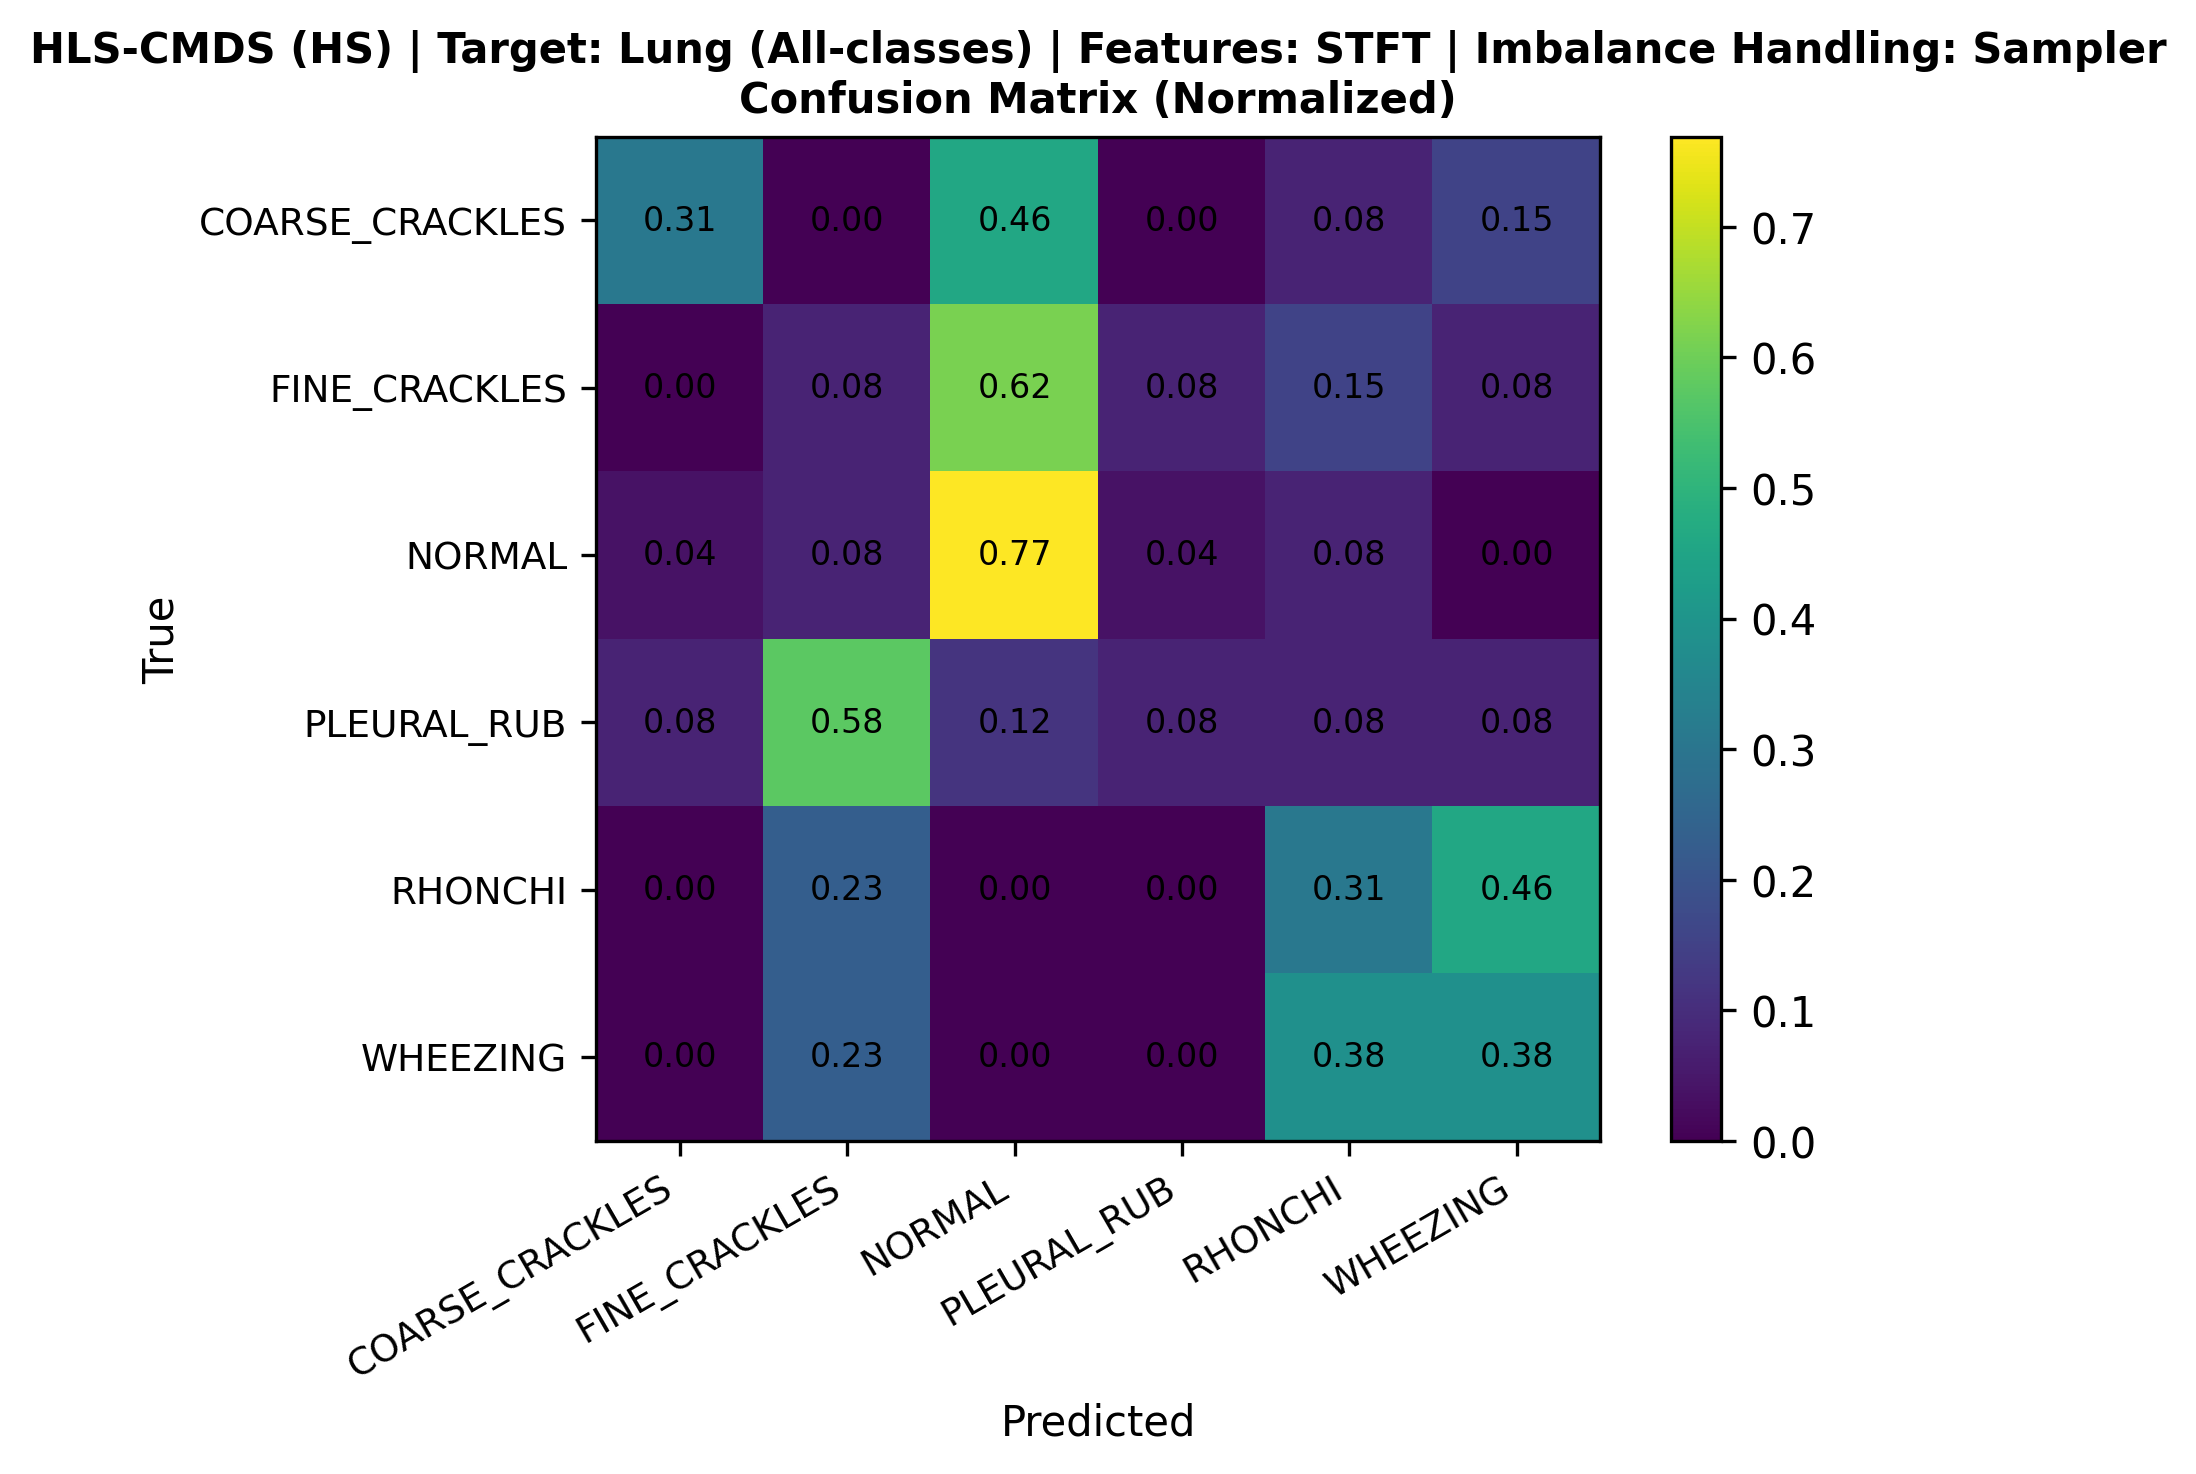

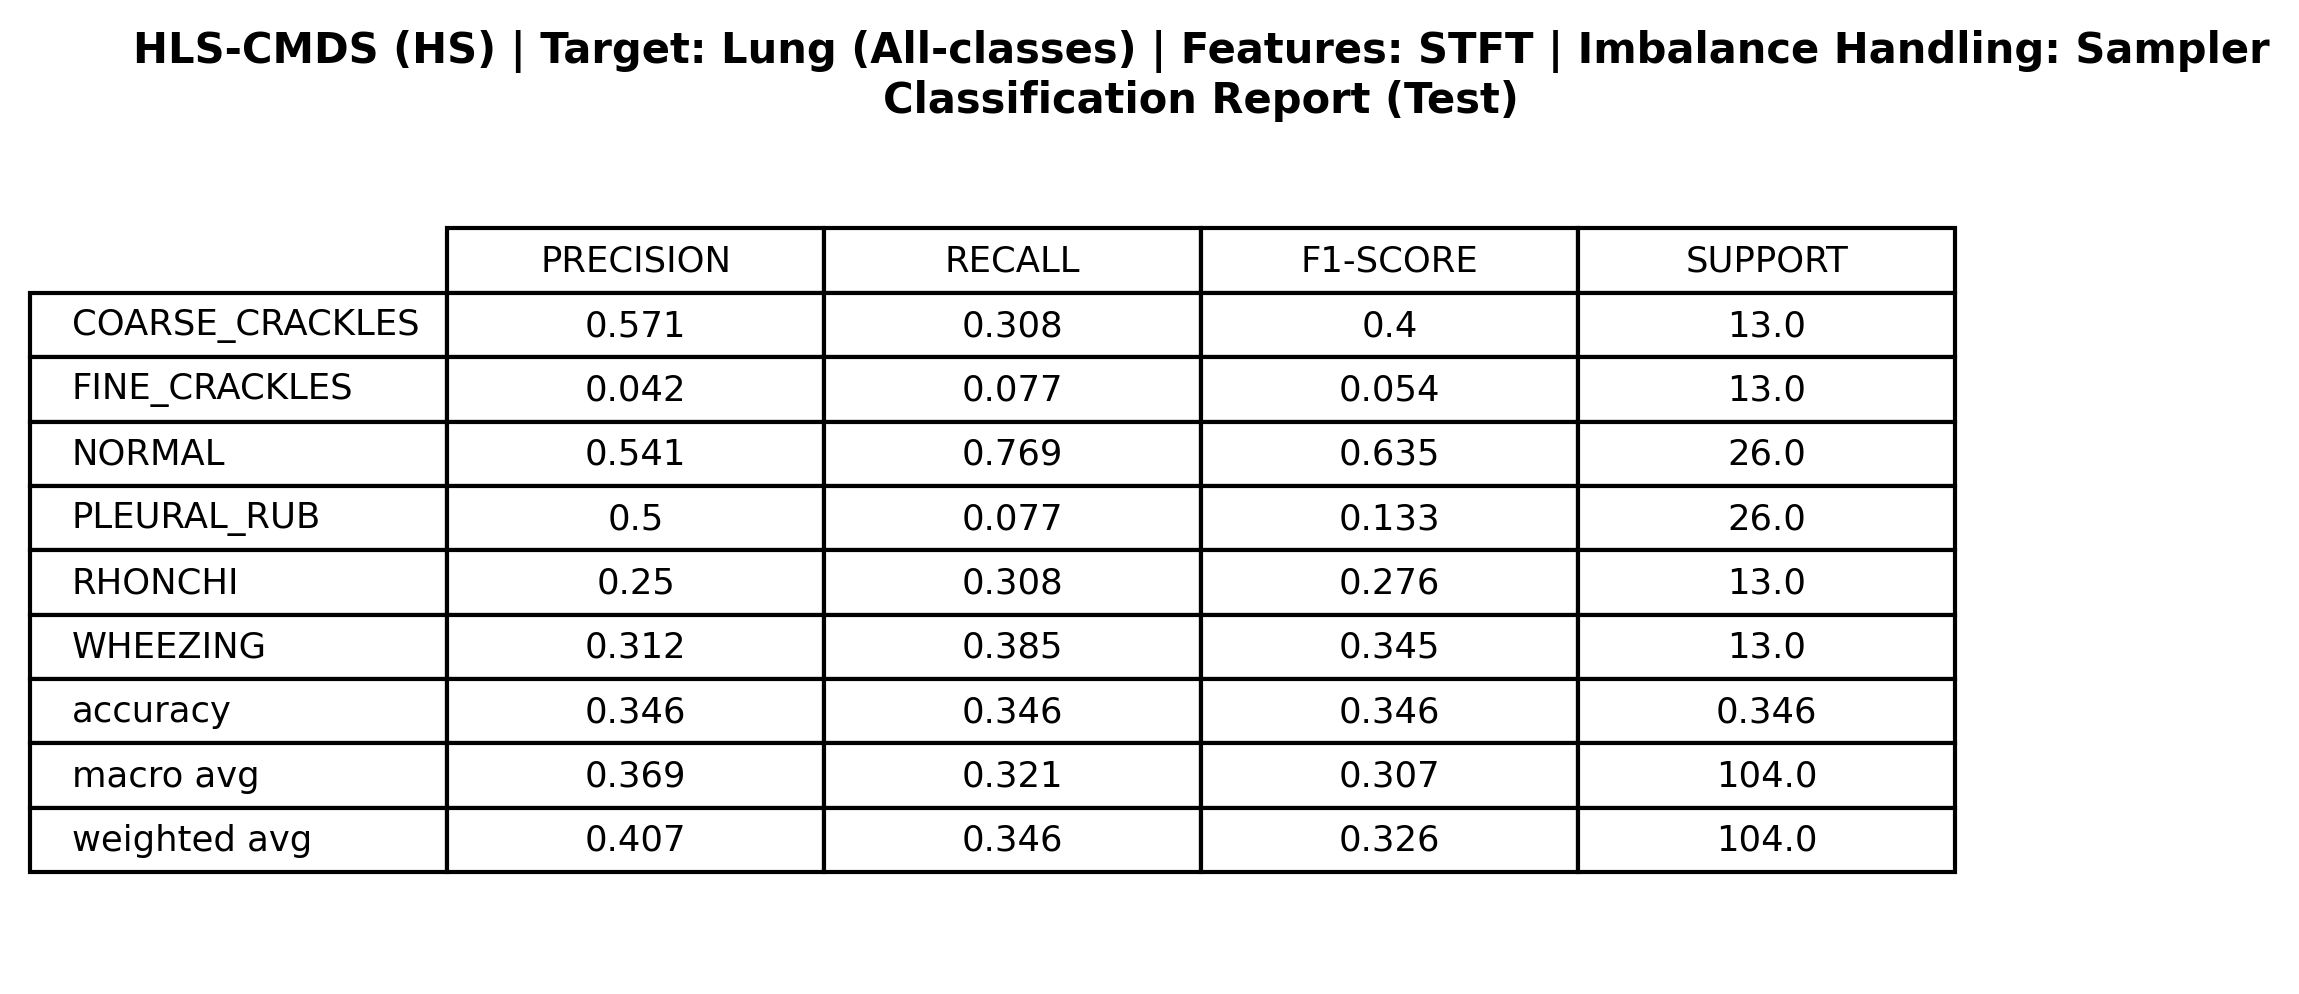

In [21]:
run_dirs = [OUT_DIR / r for r in summary_df["run"].tolist()]

for exp_dir in run_dirs:
    fig1 = plot_curves(exp_dir)
    plt.show(fig1)
    plt.close(fig1)

    fig2 = plot_cm(exp_dir, normalize="true")
    plt.show(fig2)
    plt.close(fig2)

    fig3 = plot_report(exp_dir)
    plt.show(fig3)
    plt.close(fig3)
